# HALIM ALBAYRAK GARANTI DATA DAY SOLUTION

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import catboost as cat
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

### EDA

In [2]:
df = pd.read_csv("data/train.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173589 entries, 0 to 173588
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CUSTNBR          173589 non-null  float64
 1   TRAN_DATE        173589 non-null  object 
 2   ADDCONTAMNT      173589 non-null  int64  
 3   ACCMVMTAVG       140480 non-null  float64
 4   ACCAMNTAVG03     138509 non-null  float64
 5   ACCACVNUM12      154577 non-null  float64
 6   ACCAMNTAVG12     132223 non-null  float64
 7   CARDDINSUM12     123997 non-null  float64
 8   DISTNUM12        173589 non-null  int64  
 9   INTPHNNUM03      173589 non-null  int64  
 10  INTLOGNUM12      173589 non-null  int64  
 11  DEMINFO1         173589 non-null  int64  
 12  DEMINFO2         173589 non-null  int64  
 13  BLNAMNT03        15780 non-null   float64
 14  CRRASTALL        172485 non-null  float64
 15  ASTAVGDIF0312    168030 non-null  float64
 16  EFTAMNTSUM12     86544 non-null   floa

In [ ]:
num_cols = [col for col in df.columns if df[col].dtype != "object"]
num_cols.pop(0)

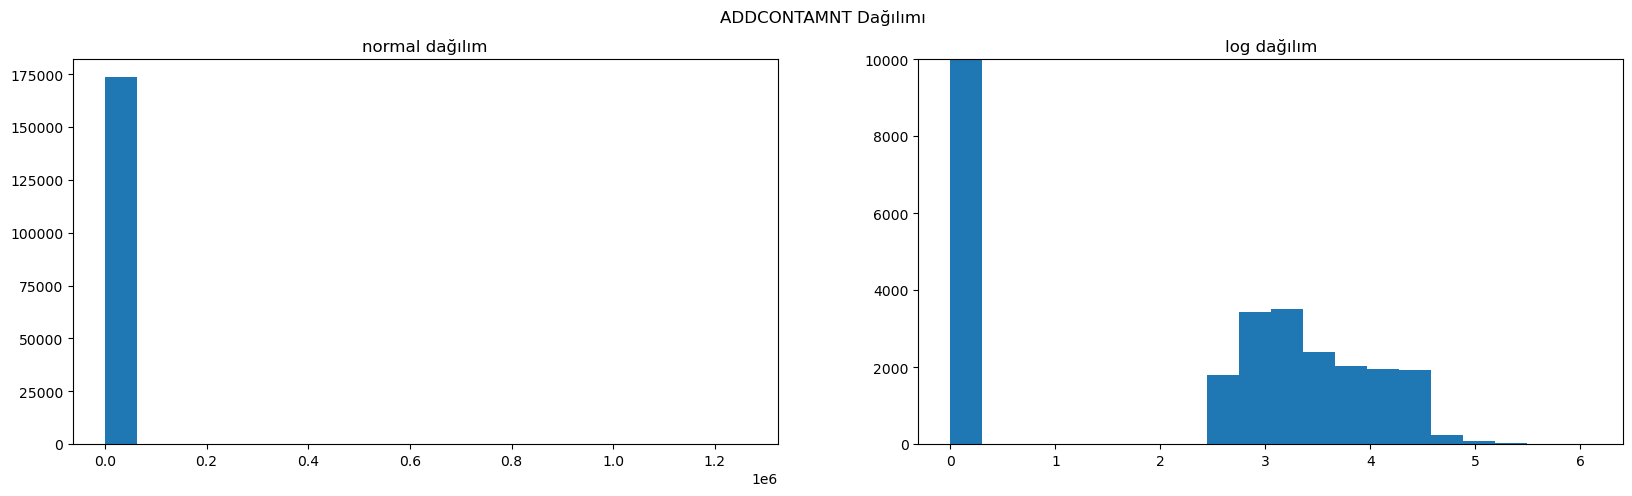

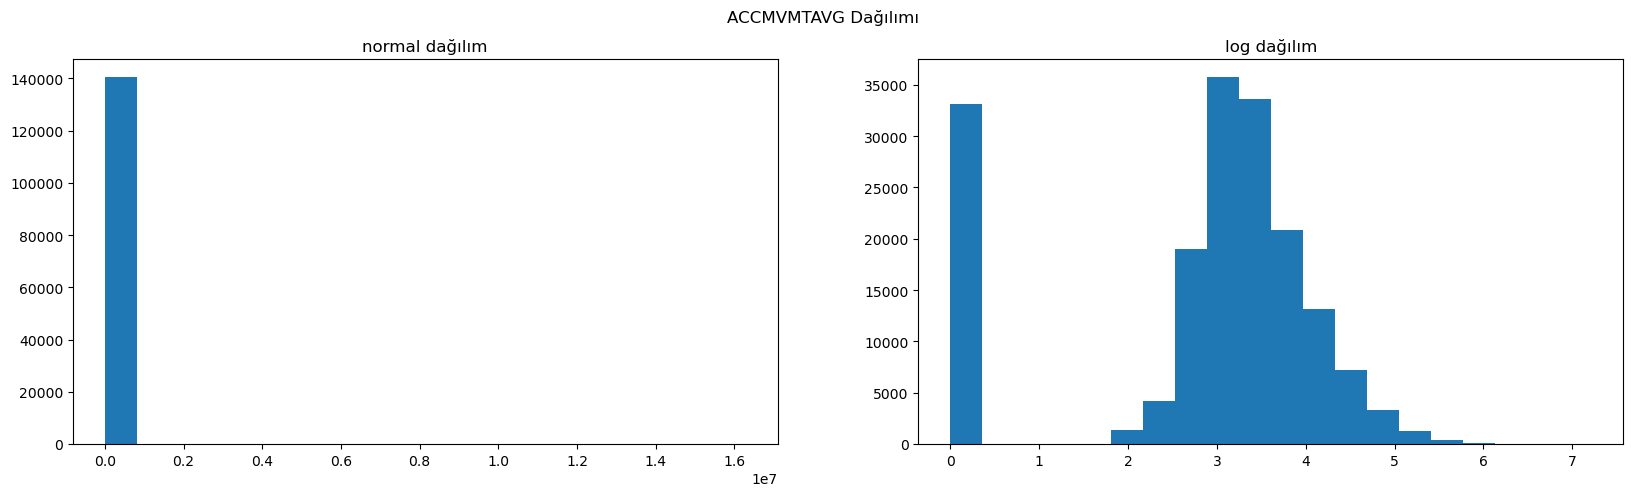

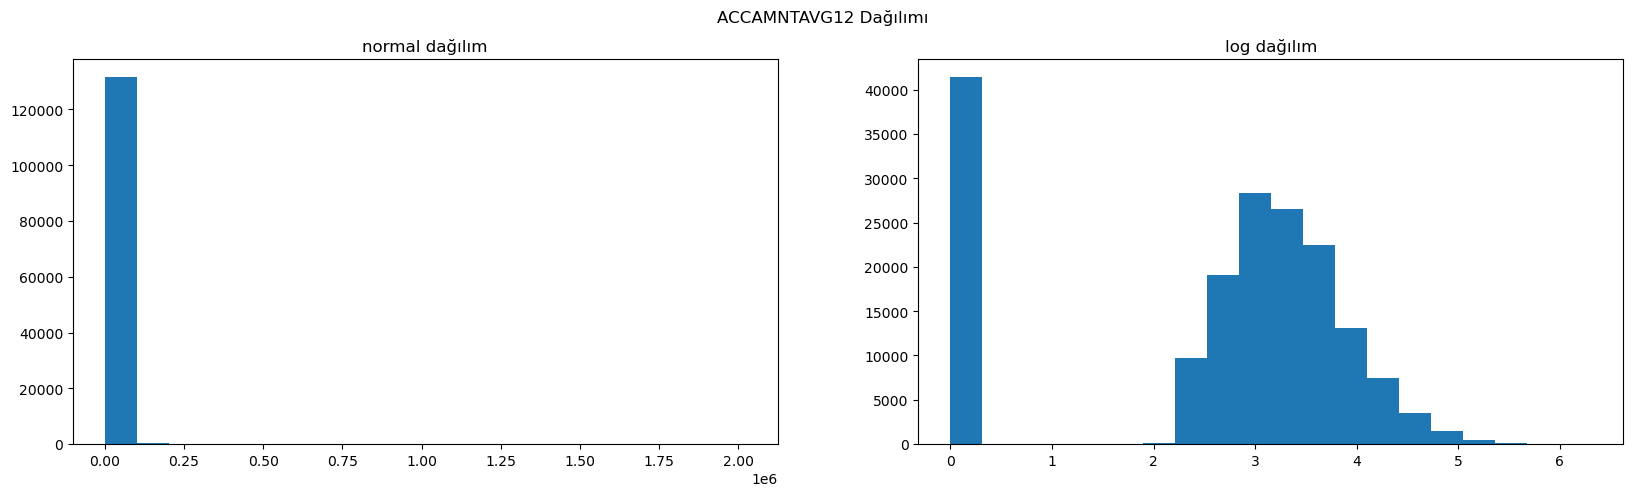

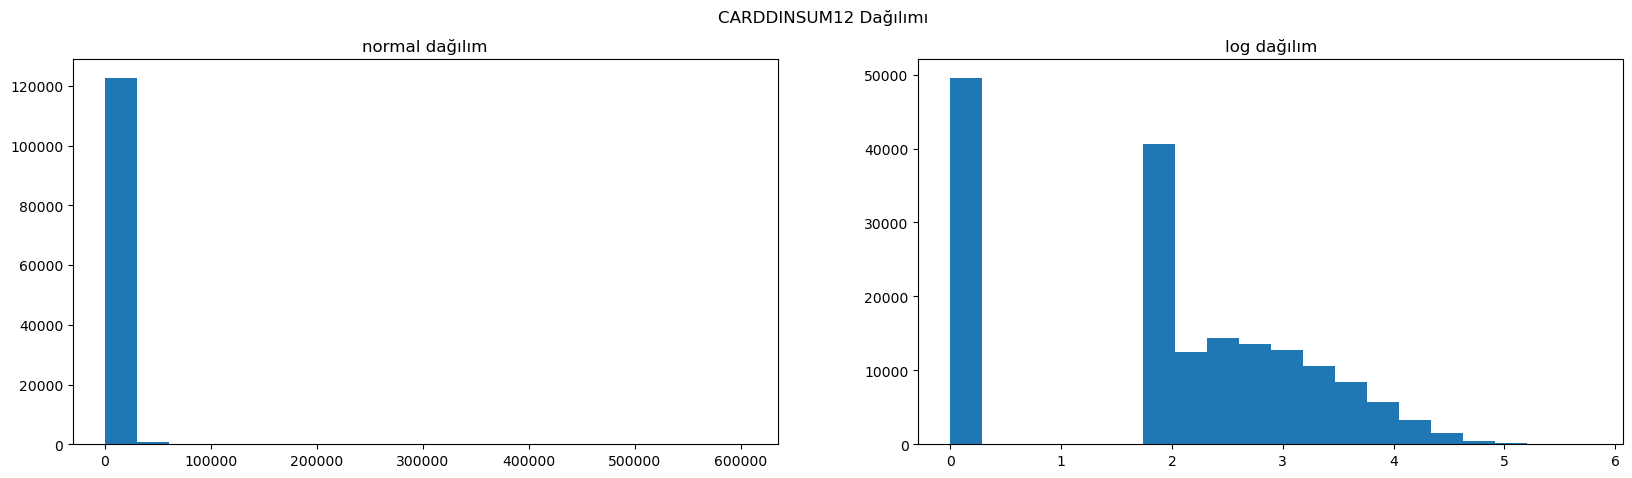

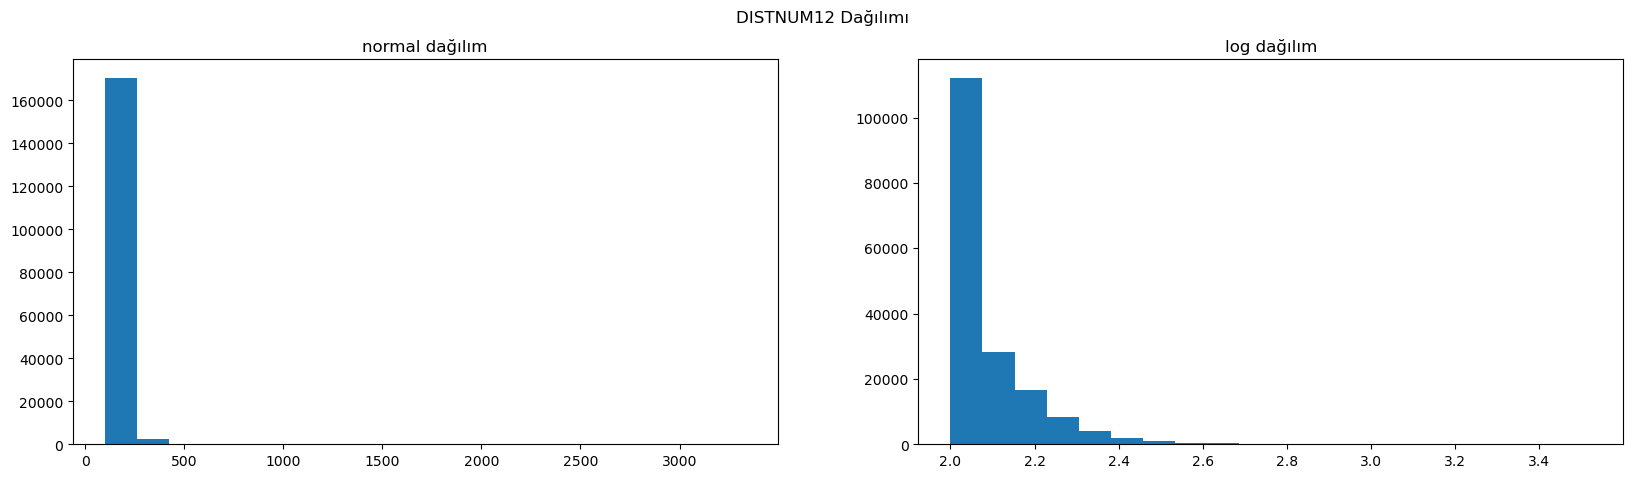

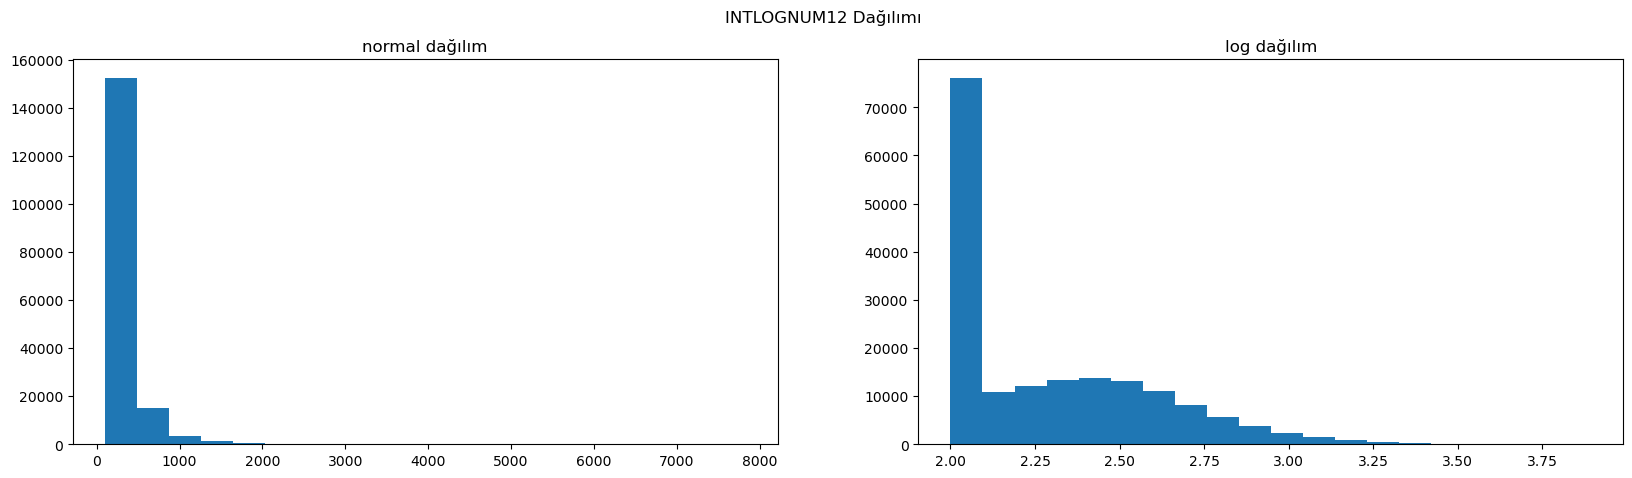

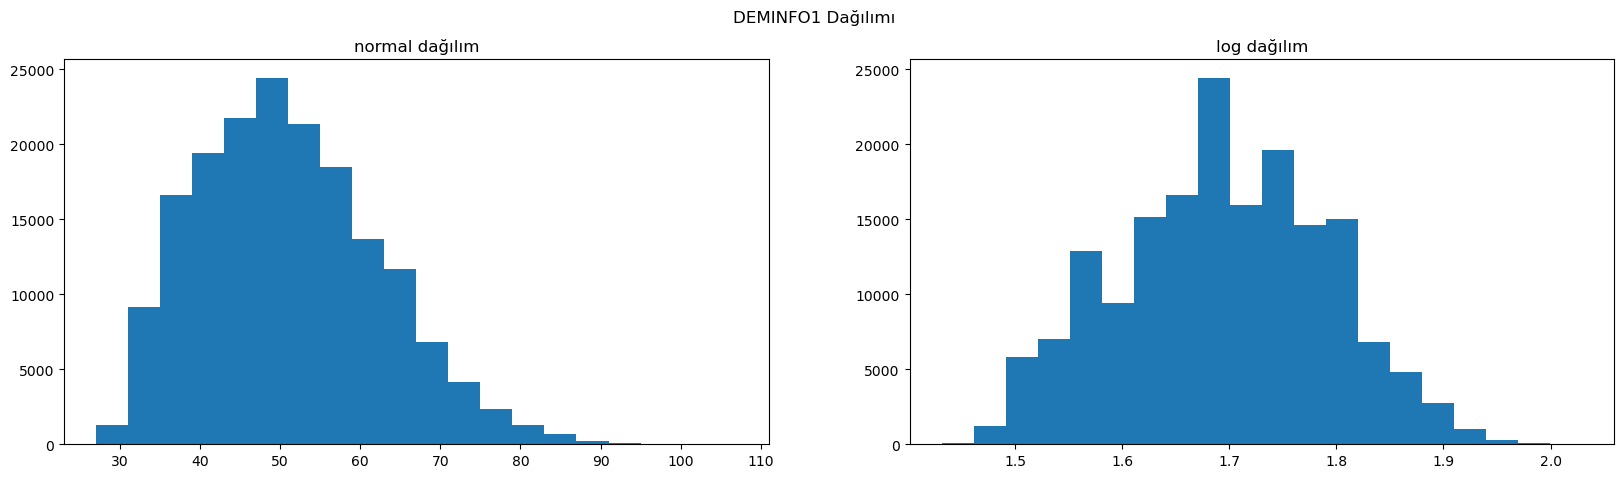

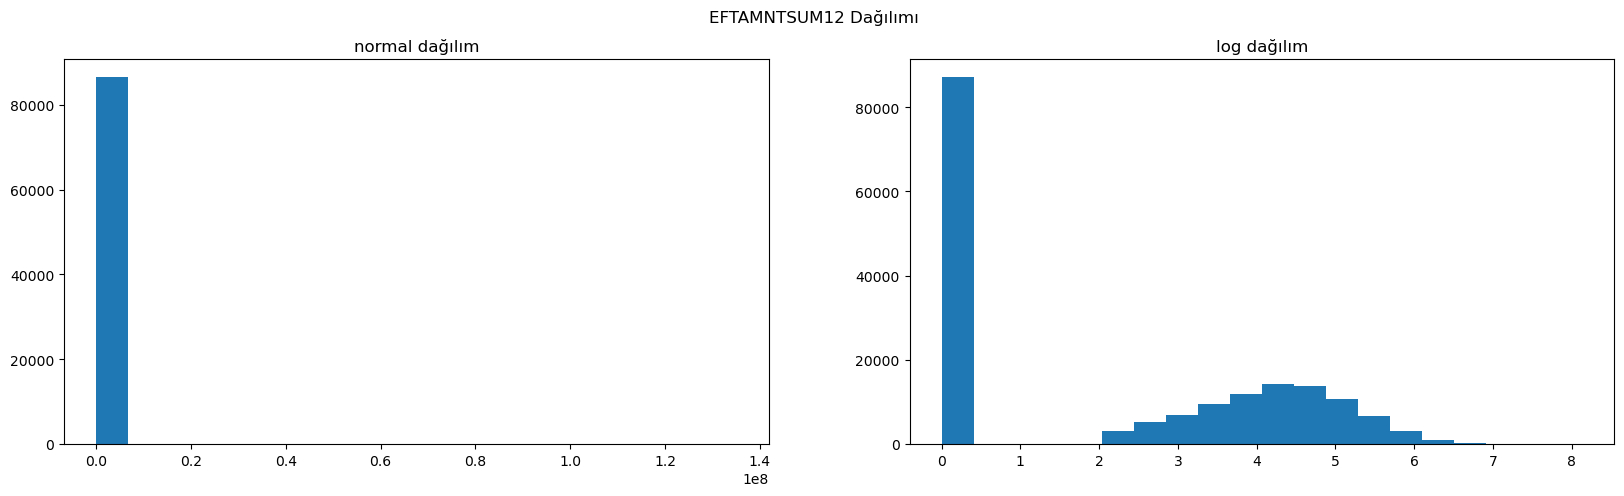

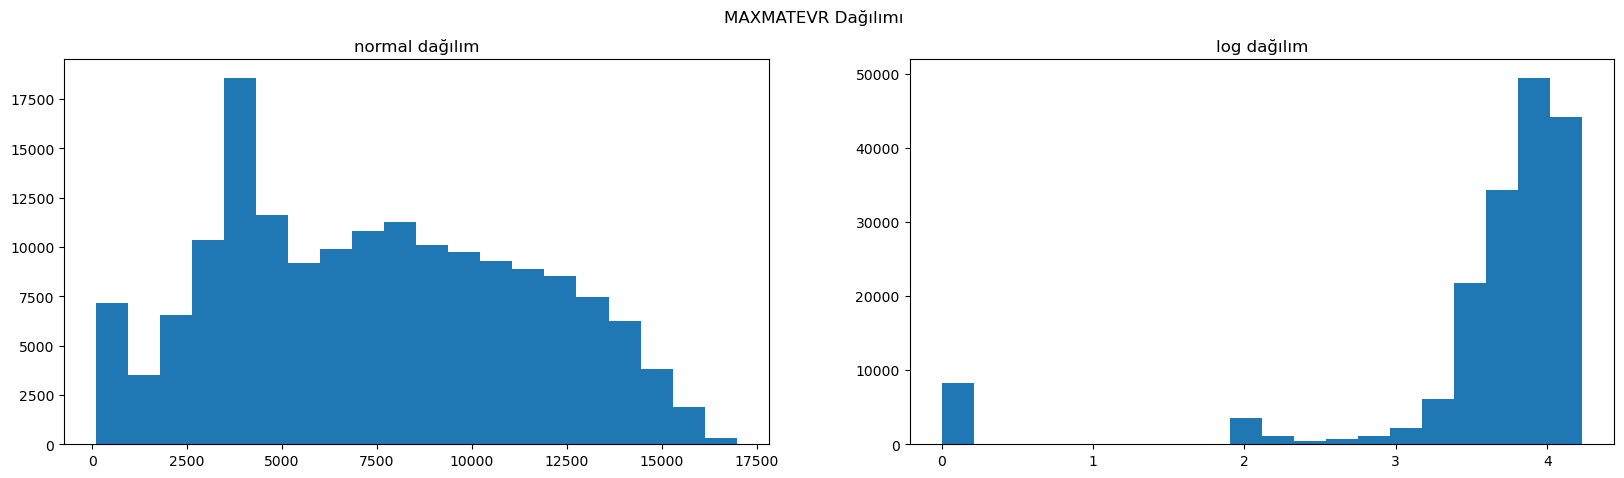

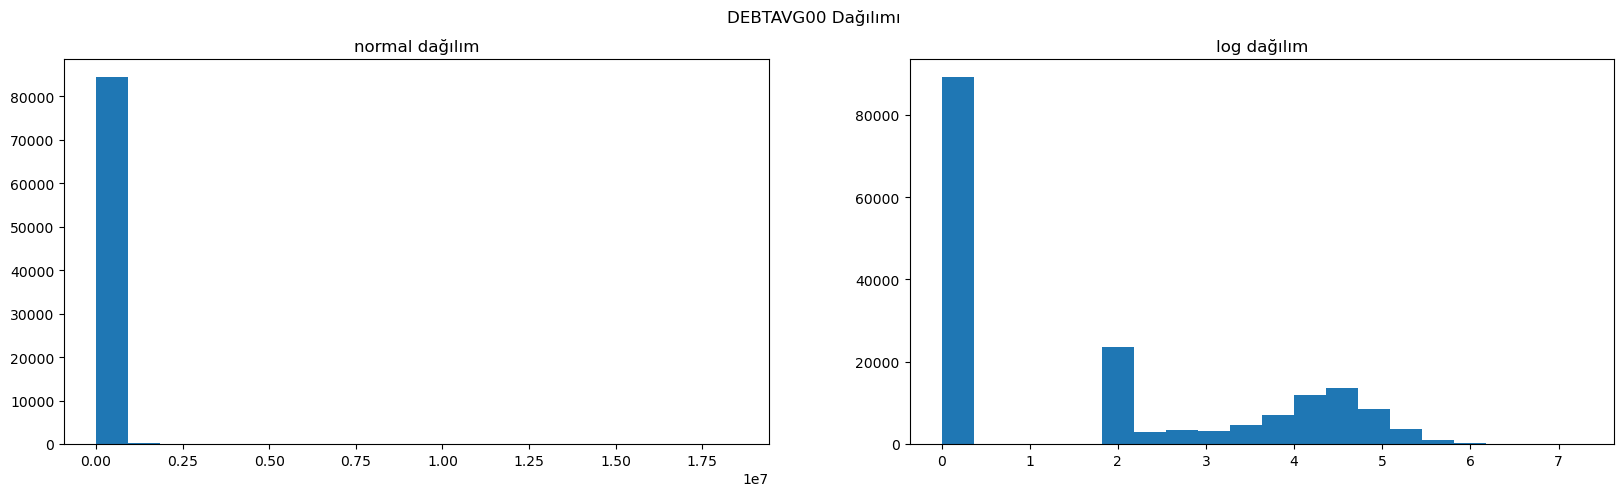

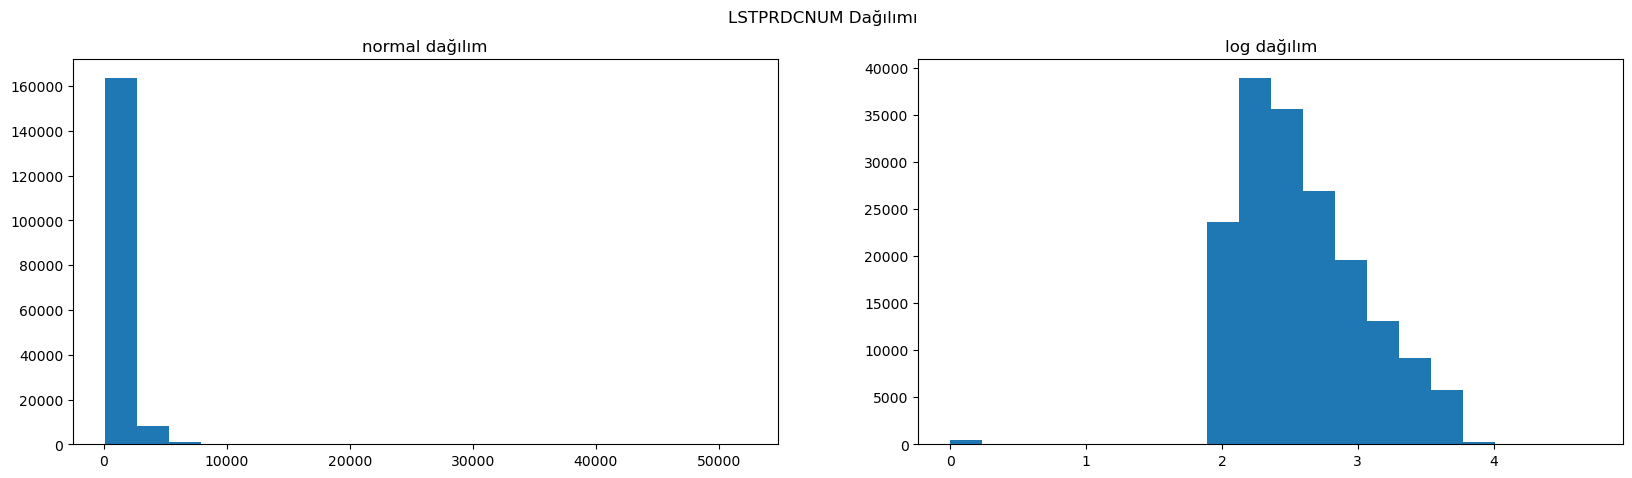

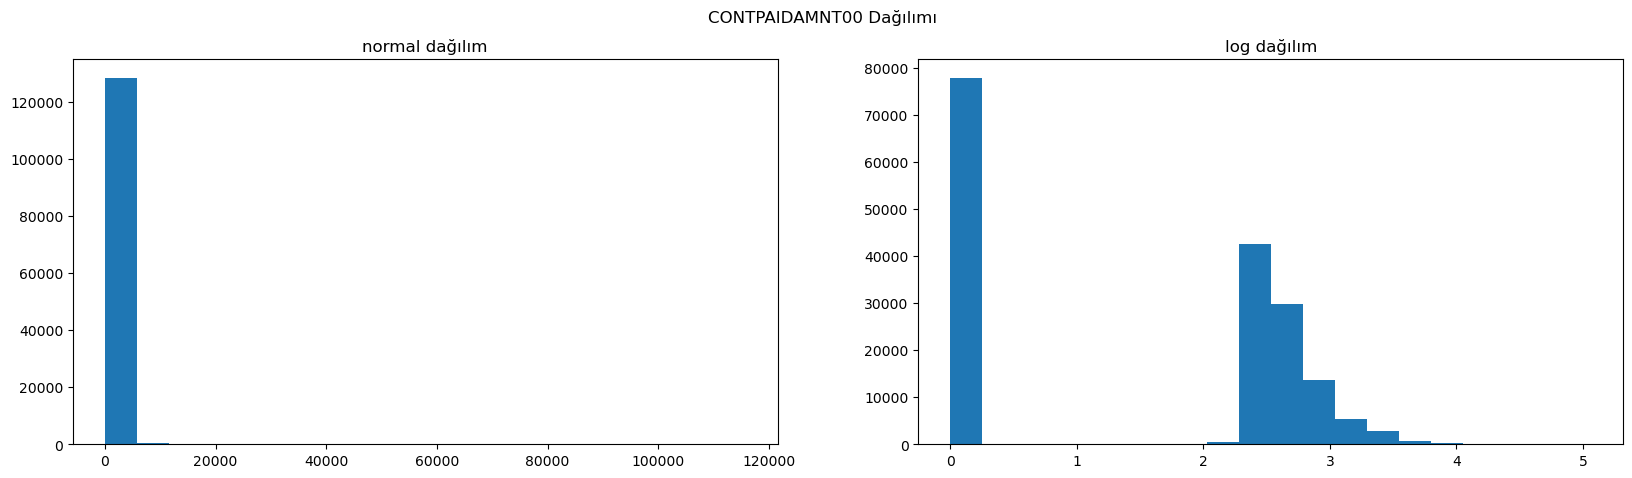

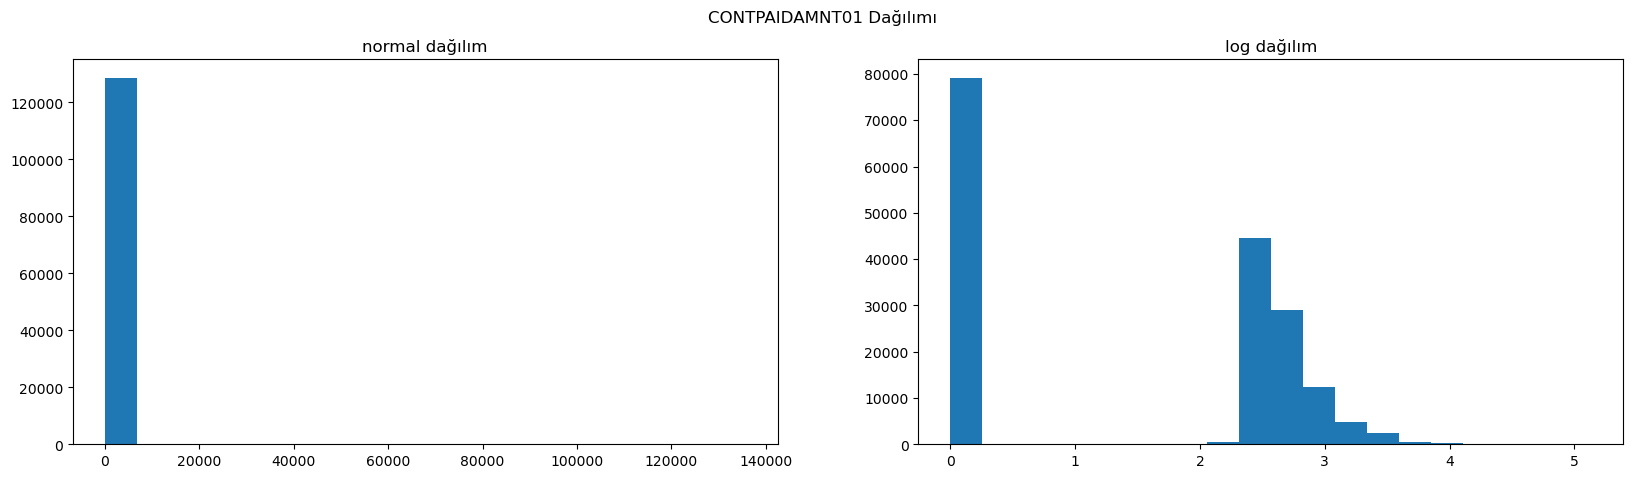

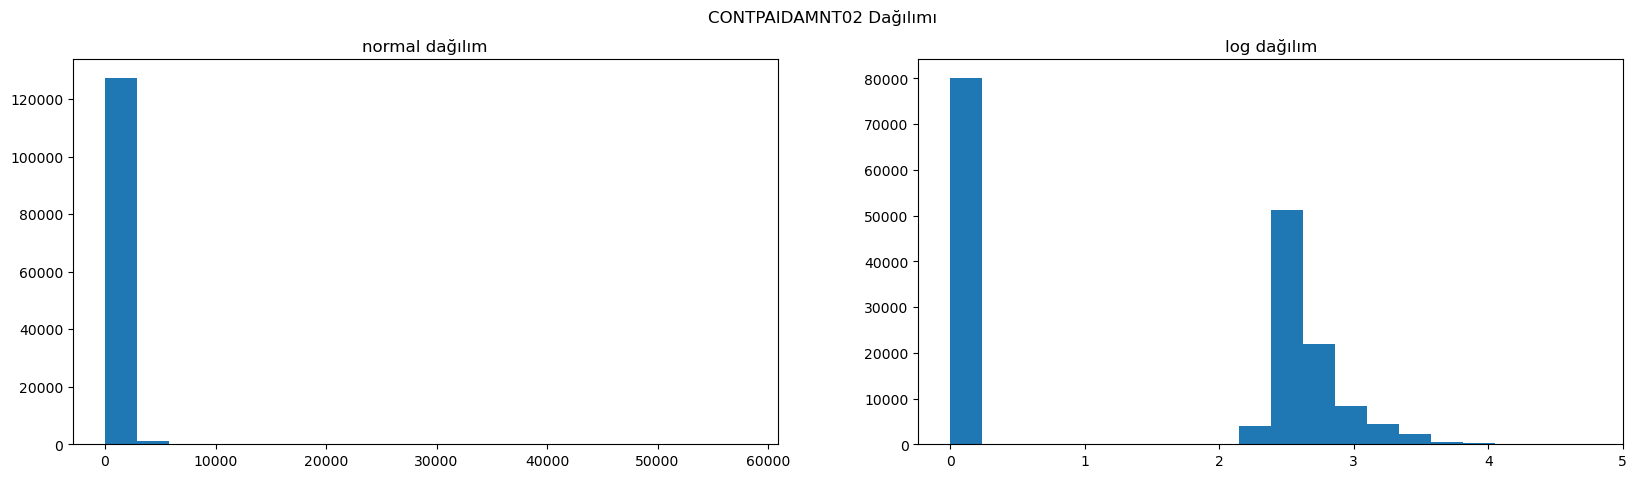

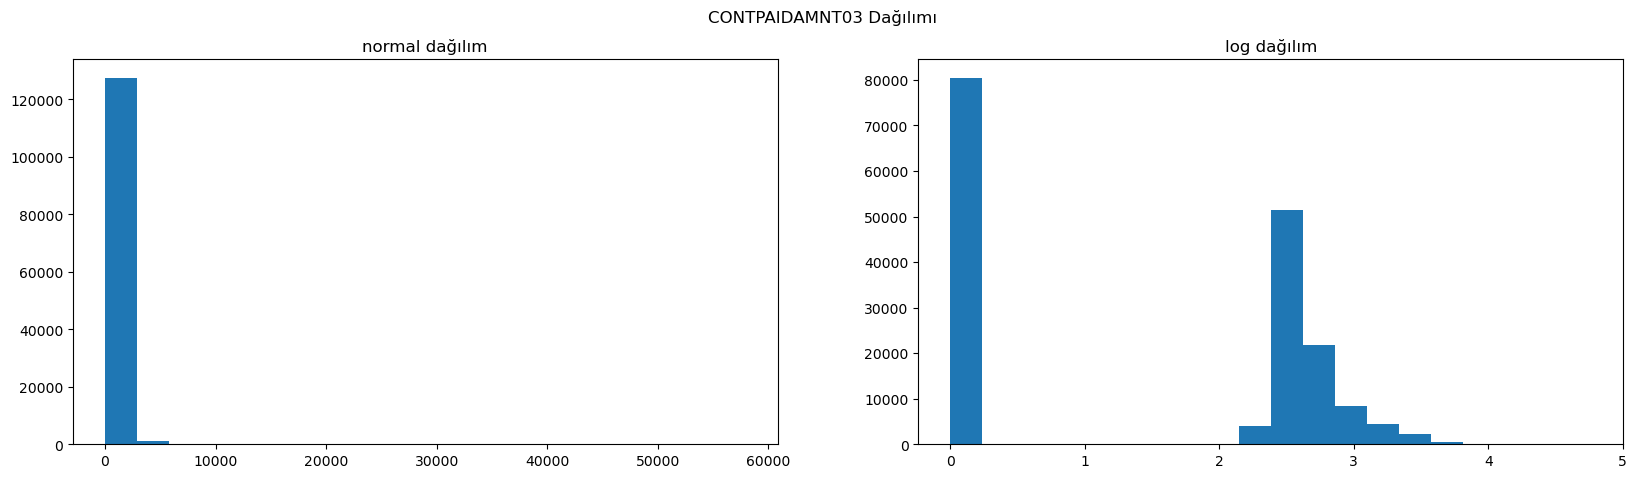

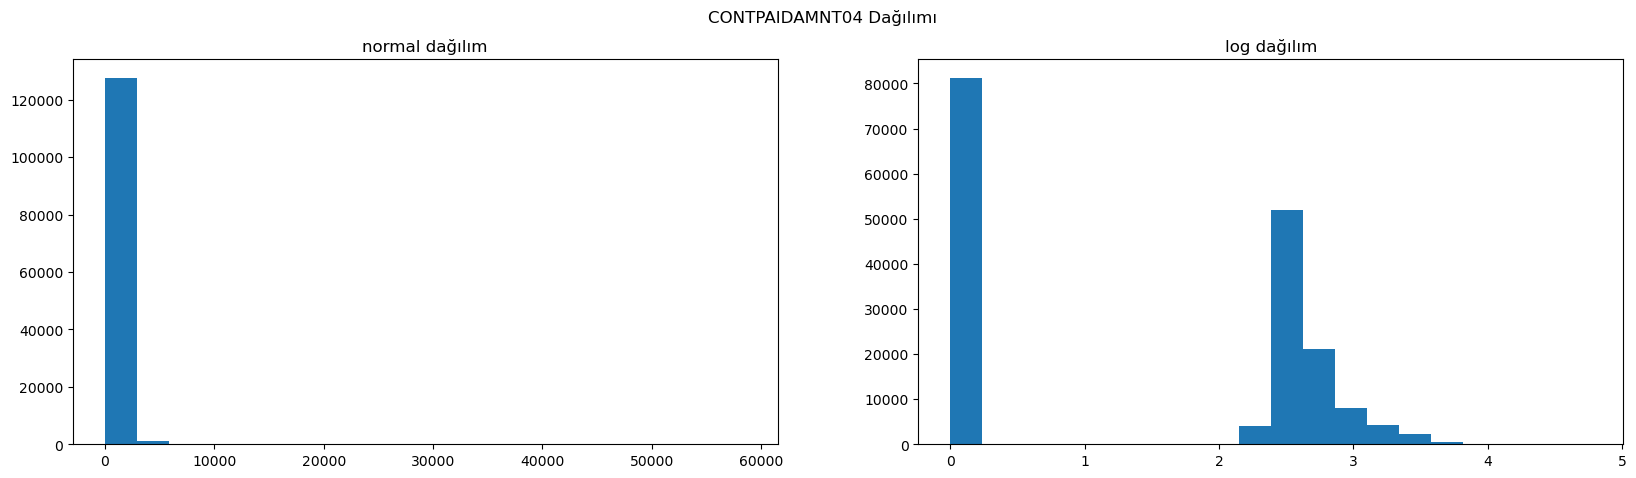

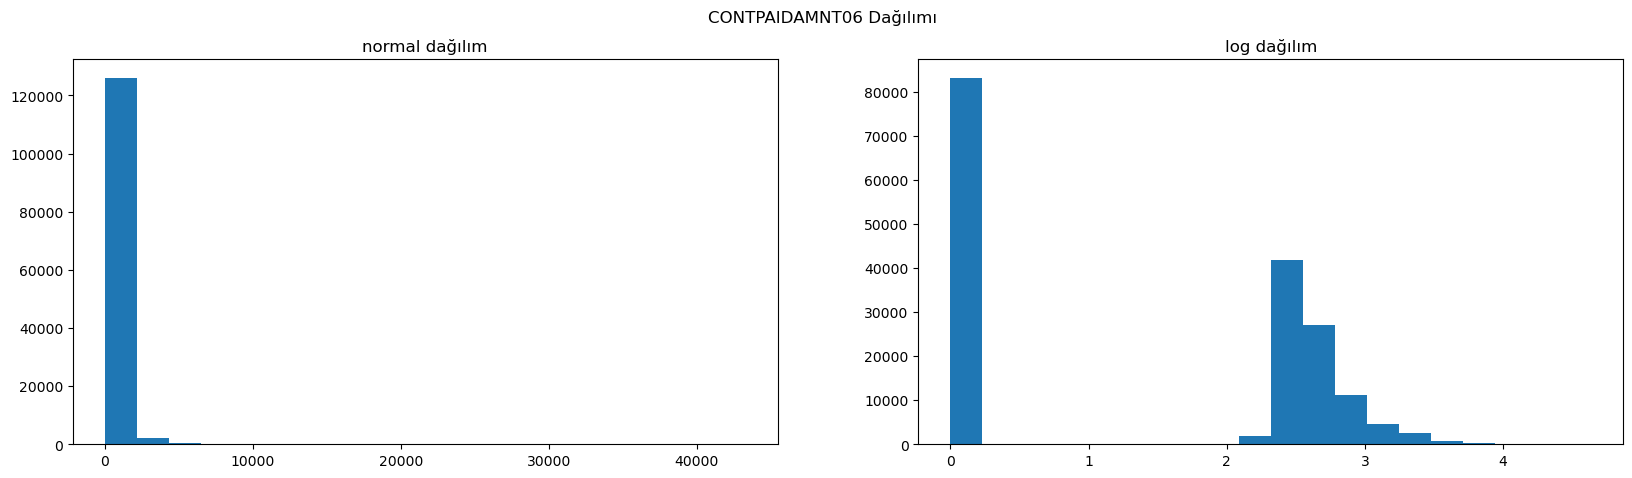

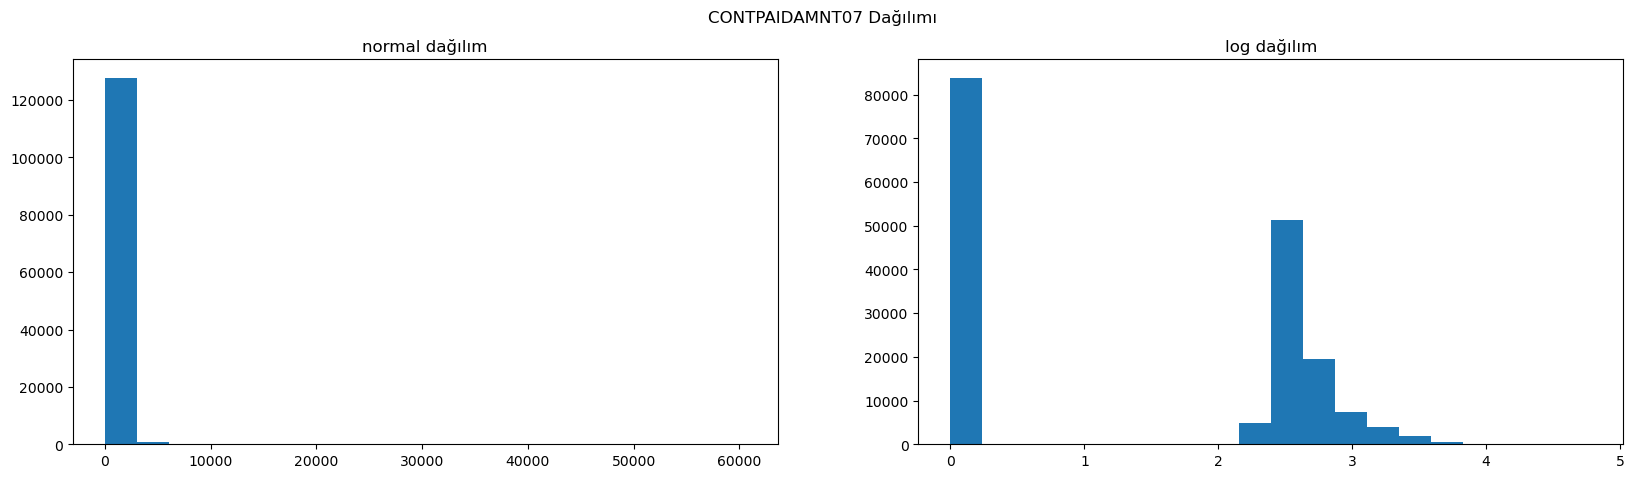

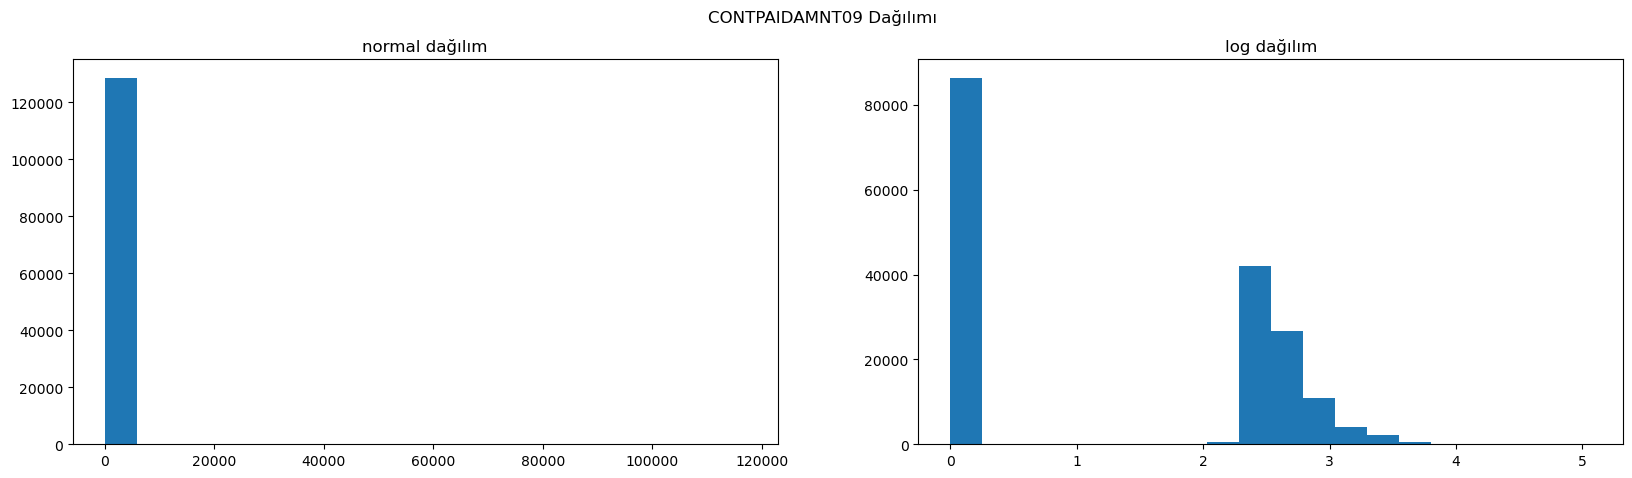

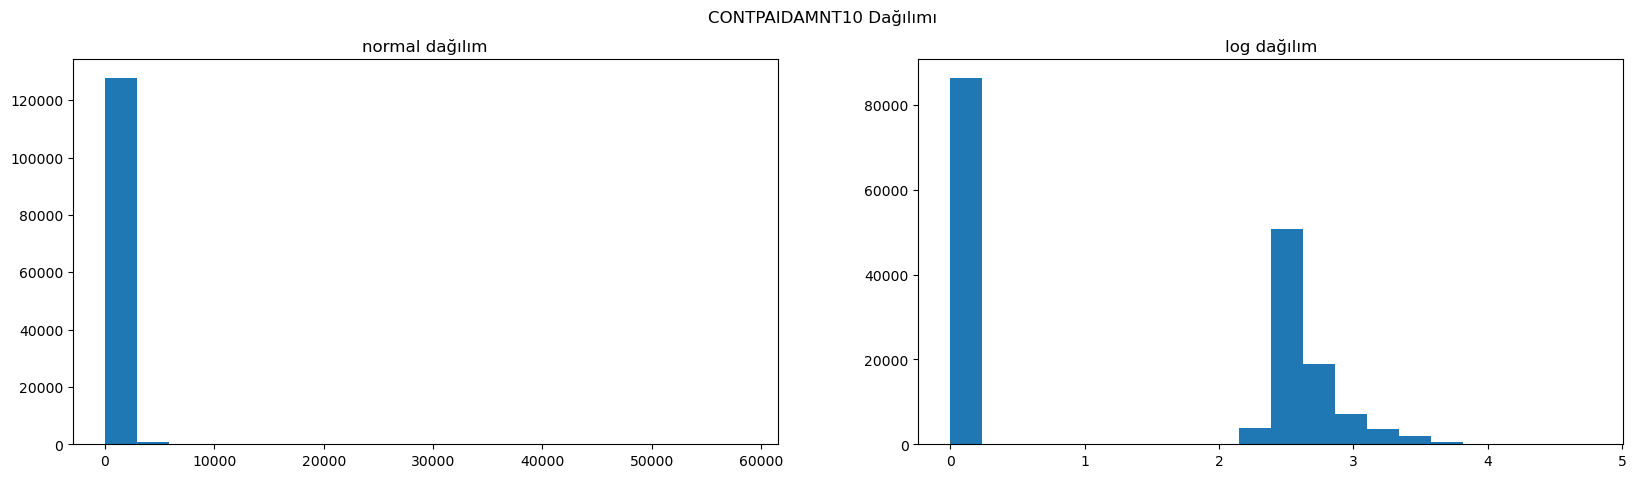

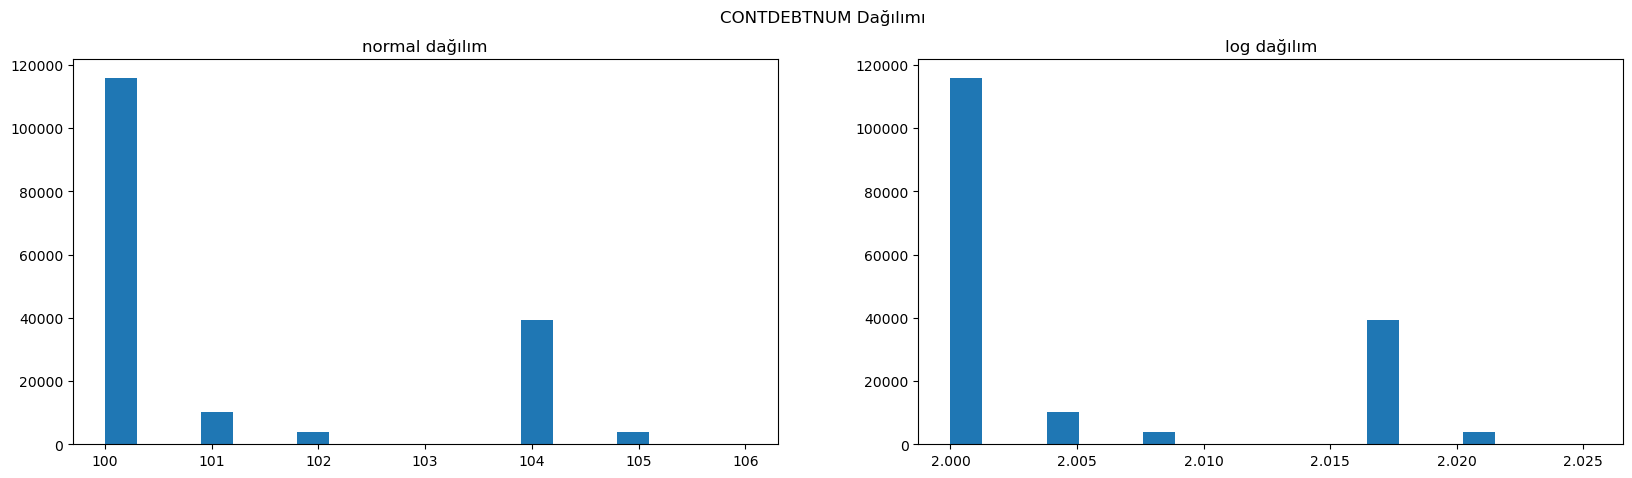

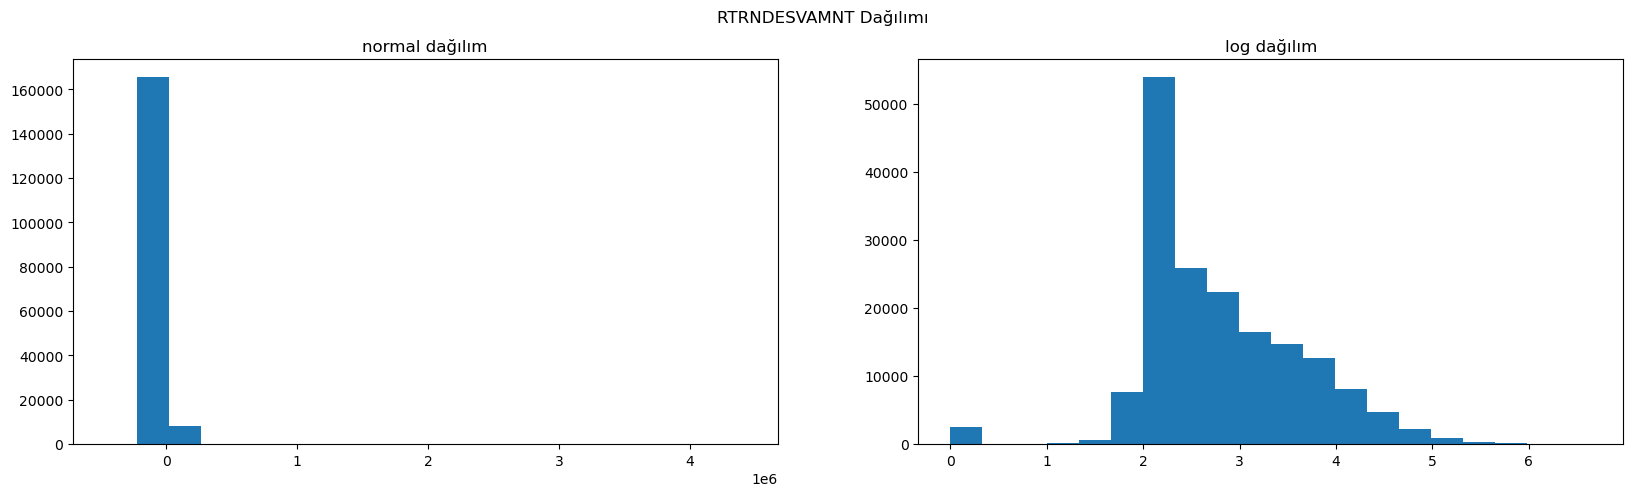

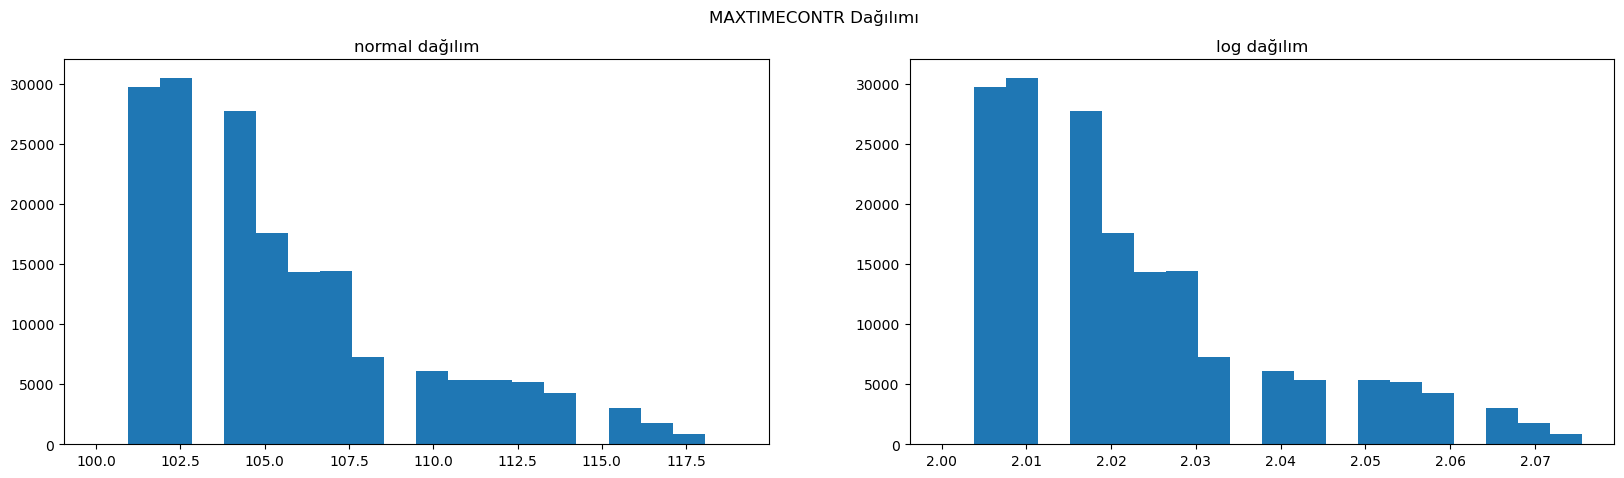

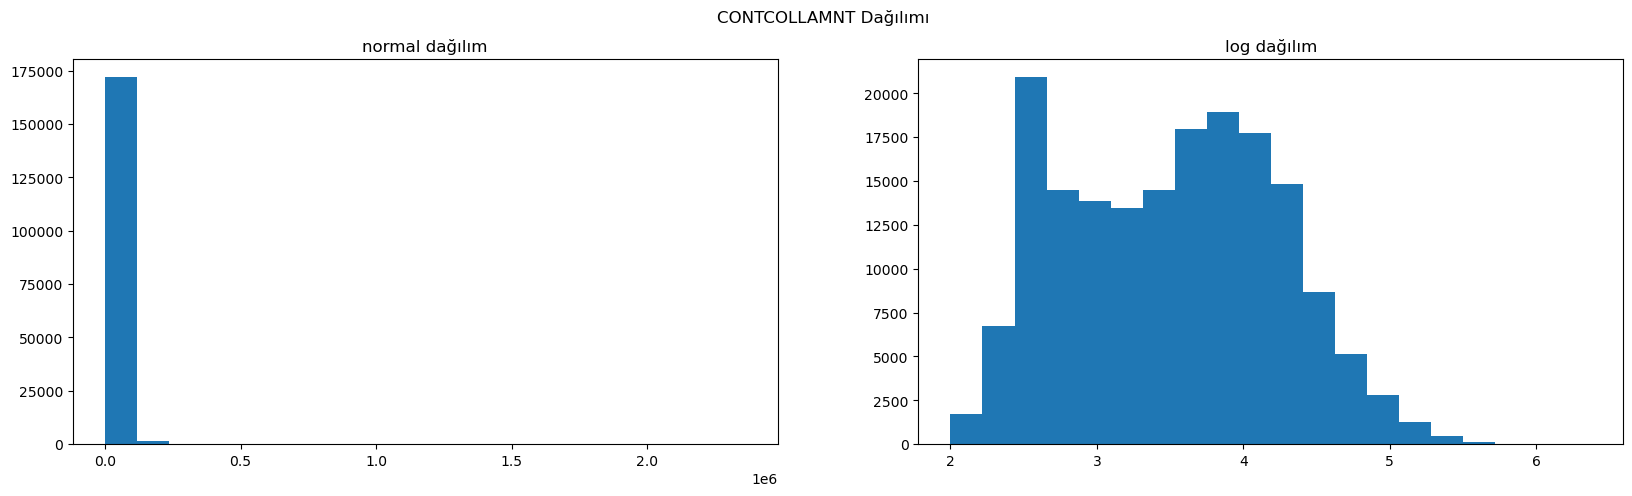

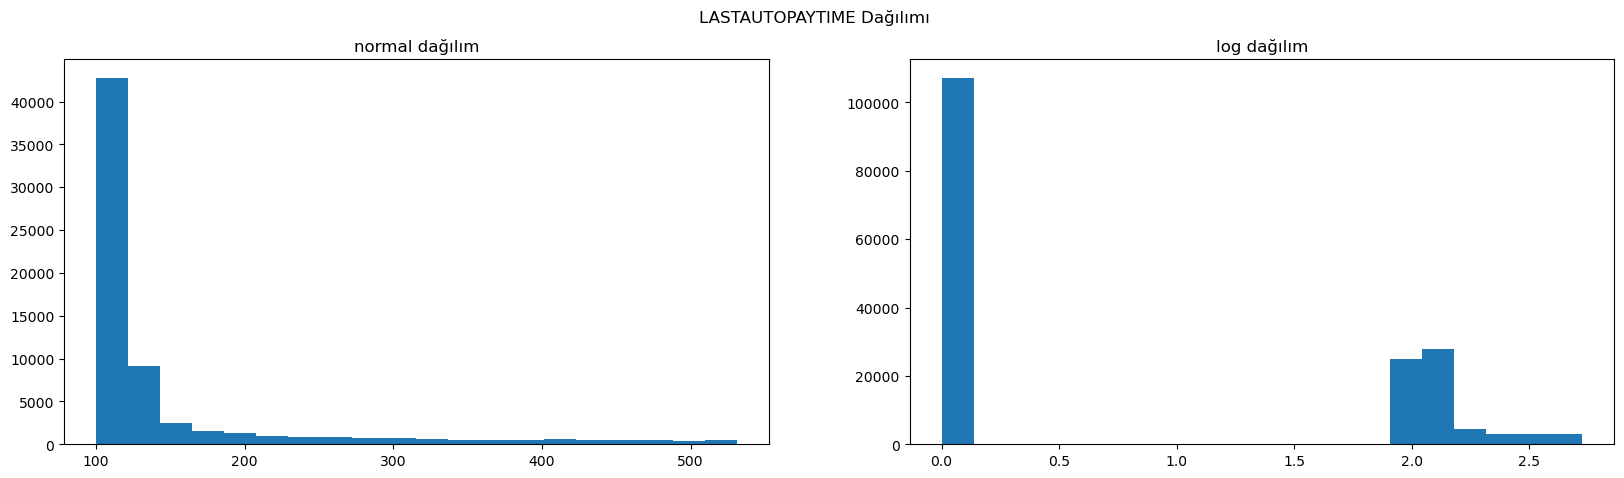

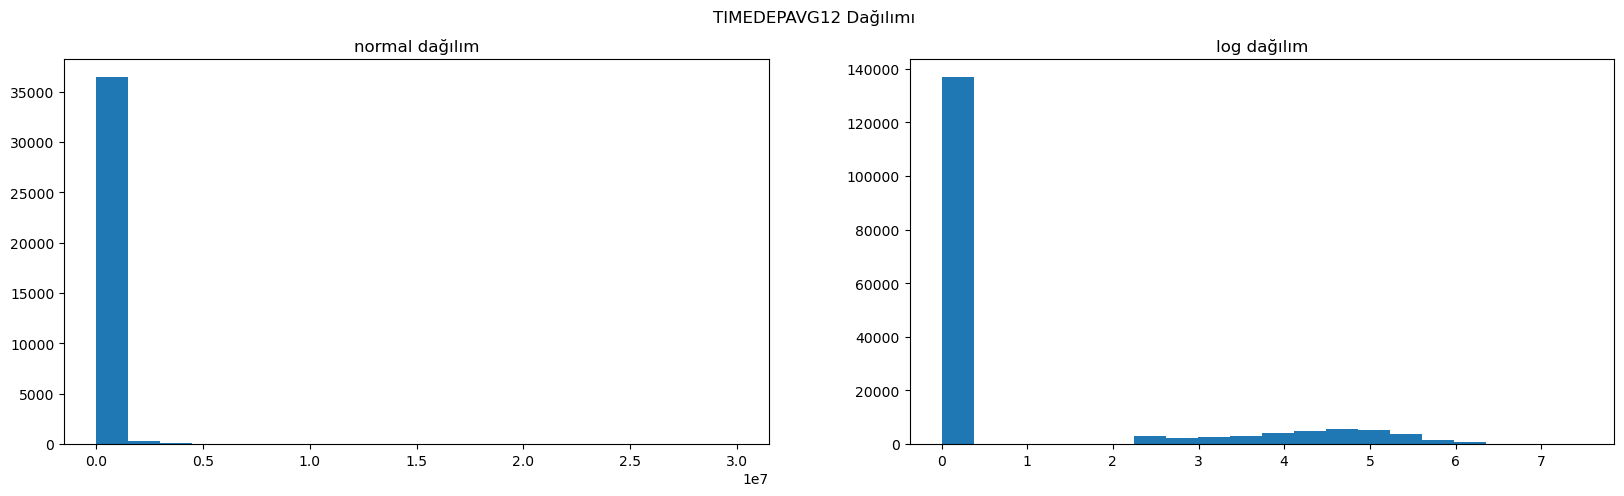

In [ ]:
for col in num_cols:
    f,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,5))
    ax1 = ax[0]
    ax1.hist(df[col],bins=20)
    ax1.set_title("normal dağılım")
    ax2 = ax[1]
    ax2.hist(df[col].apply(np.log10).replace([-np.inf,np.inf,-np.nan,np.nan],0),bins=20)
    ax2.set_title("log dağılım")
    if col == "ADDCONTAMNT":
        ax2.set_ylim(0,10000)
    plt.suptitle(f"{col} Dağılımı")
    plt.show()

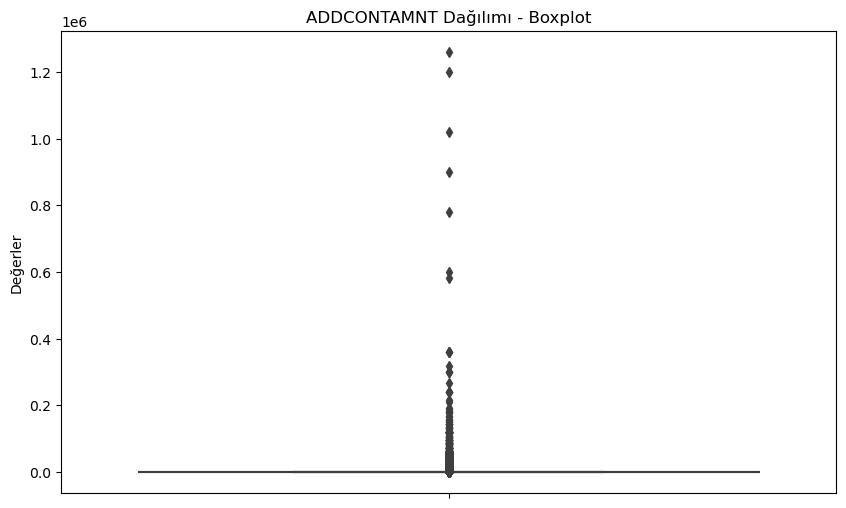

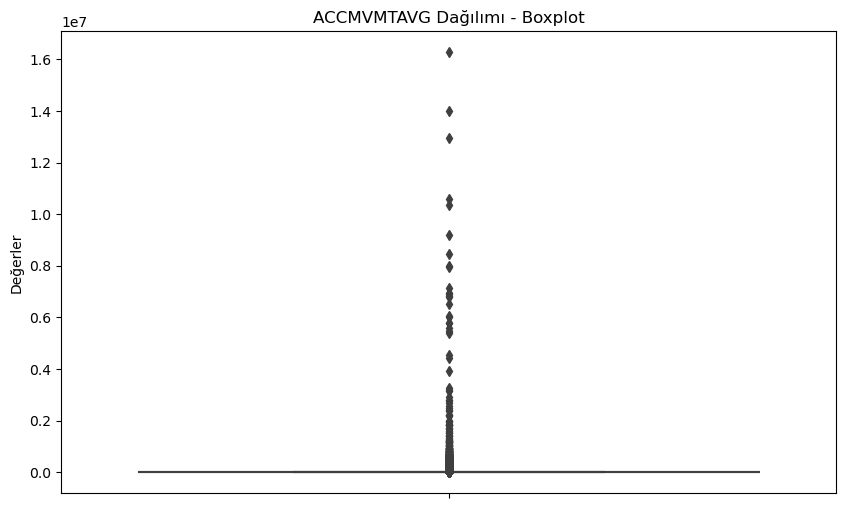

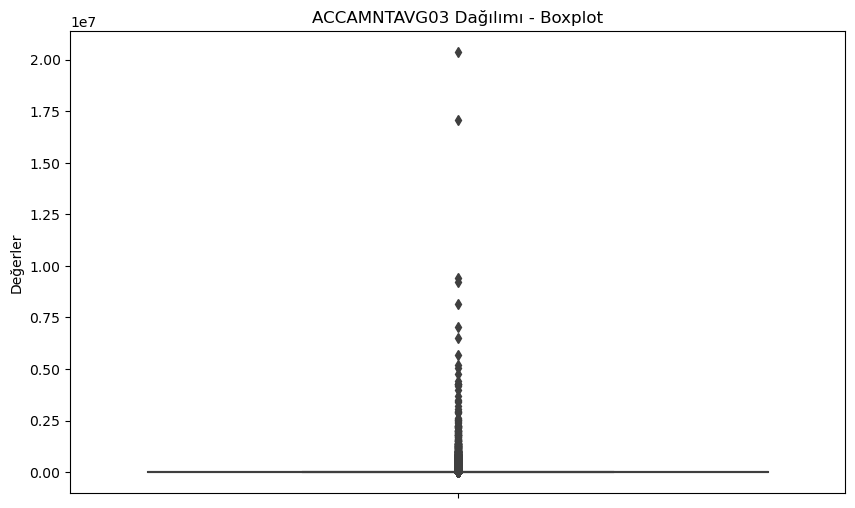

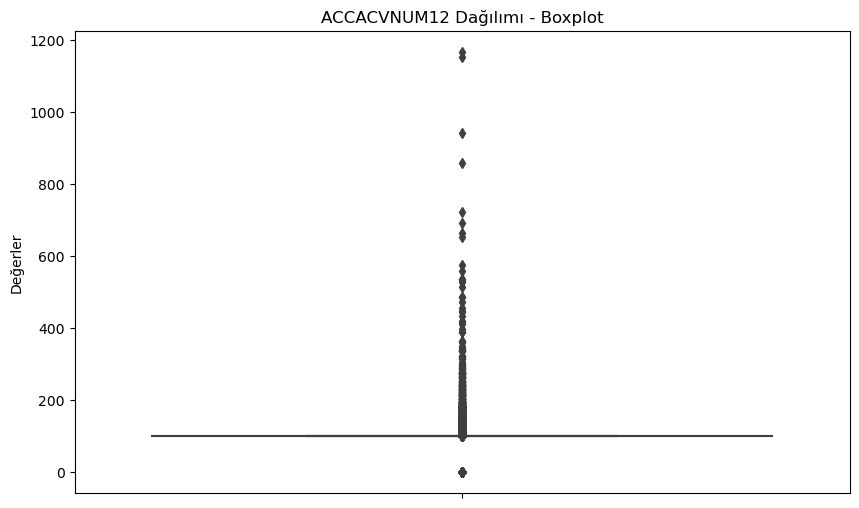

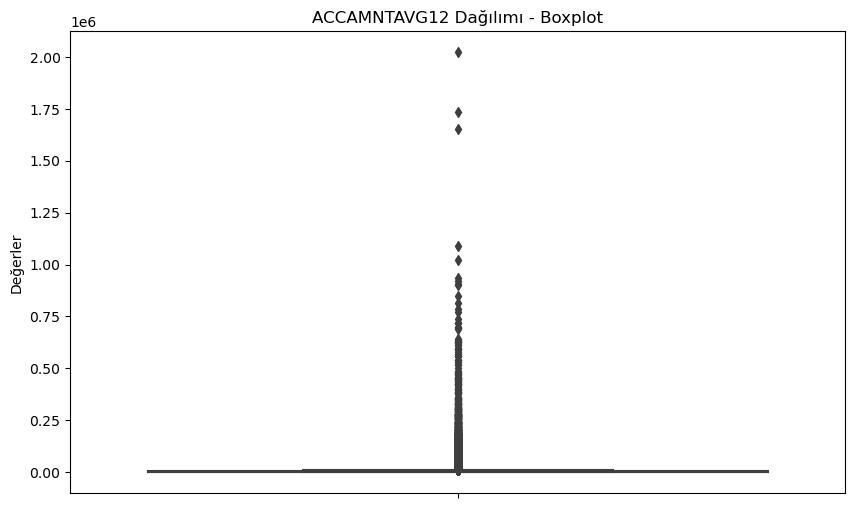

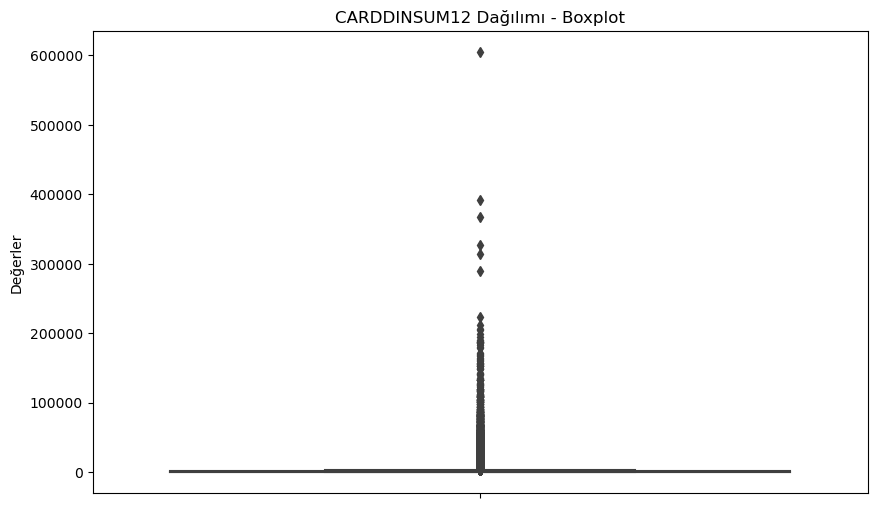

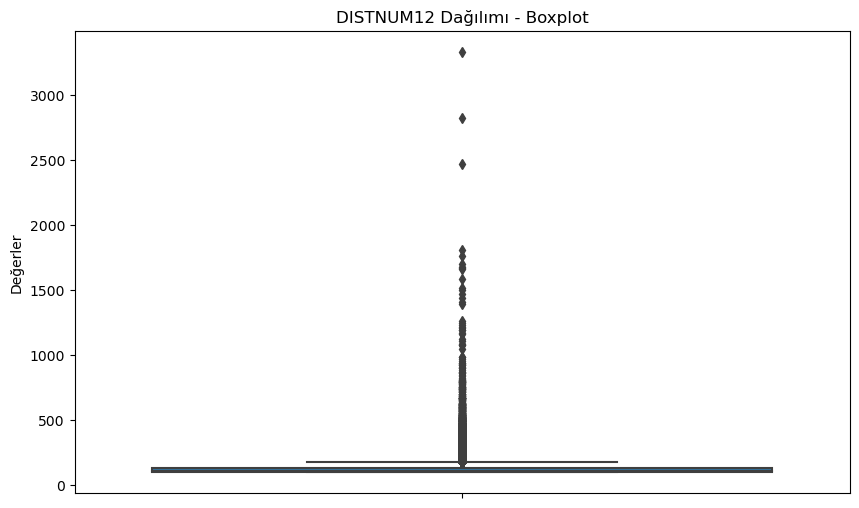

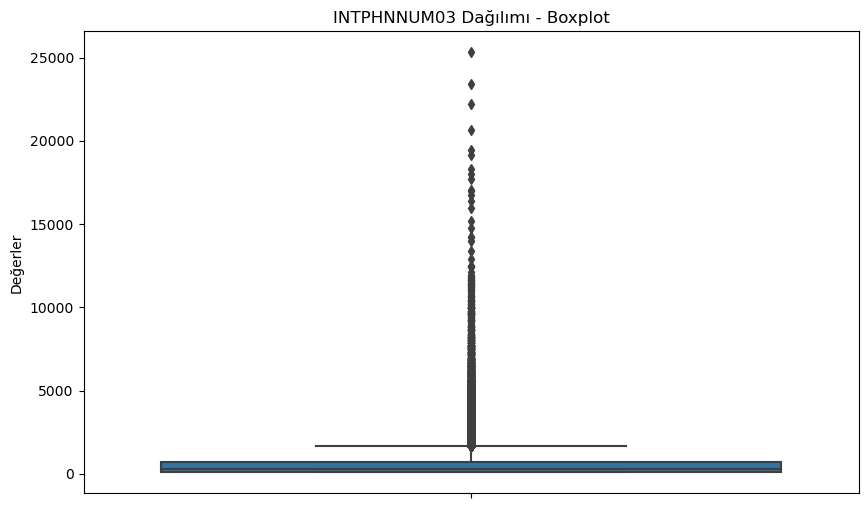

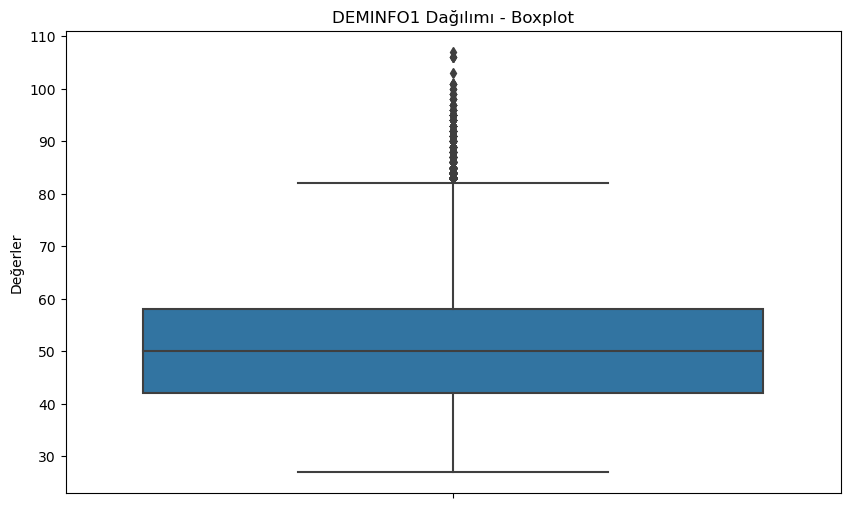

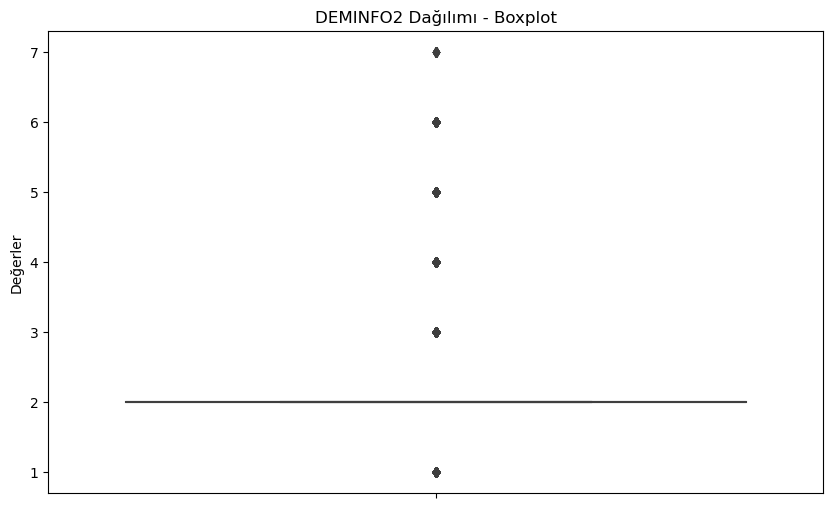

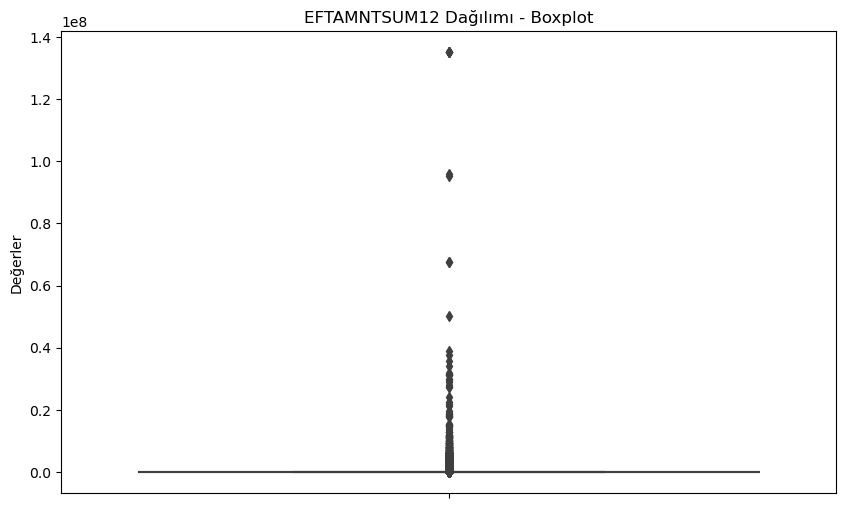

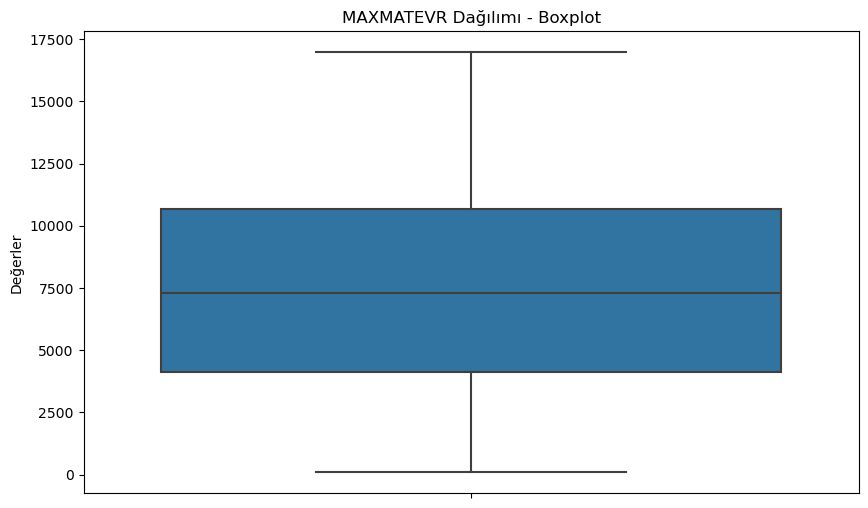

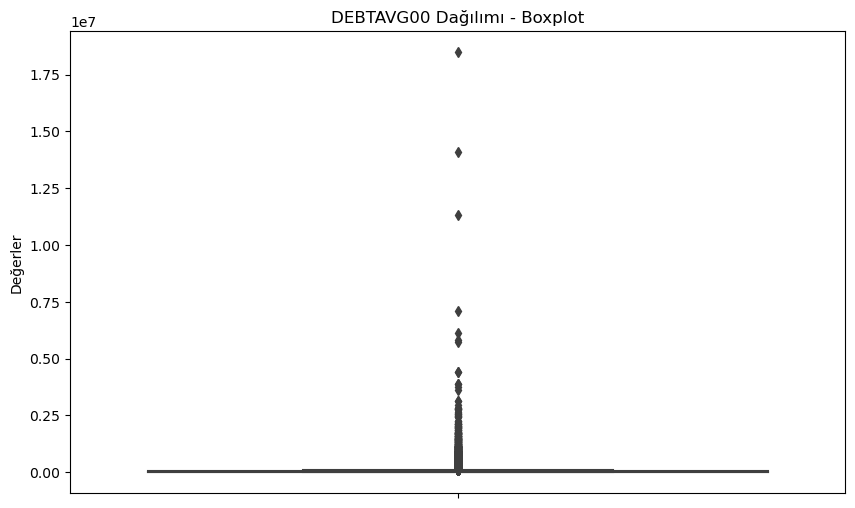

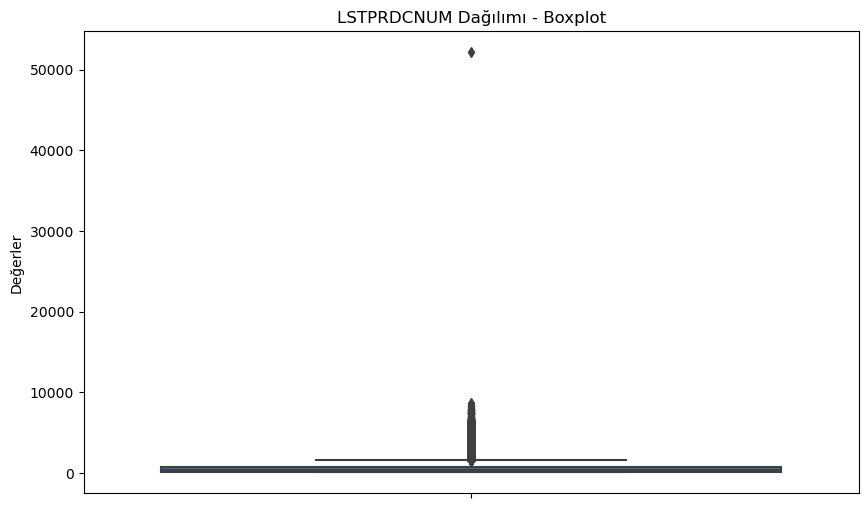

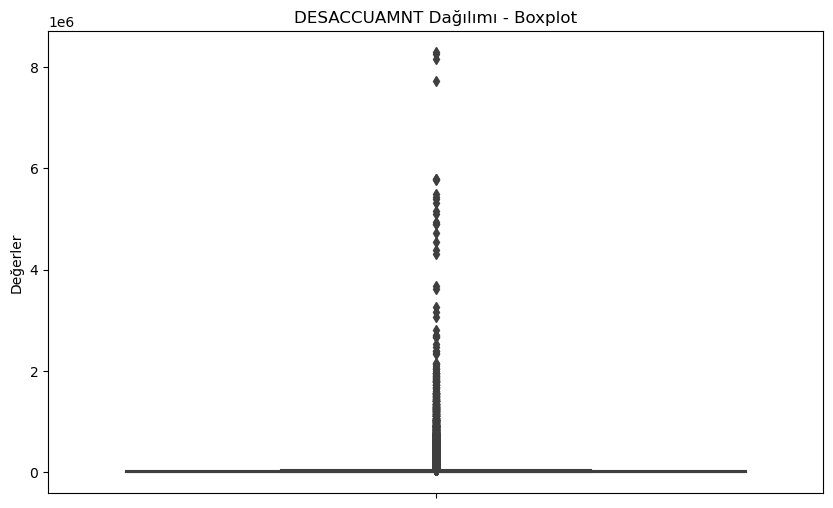

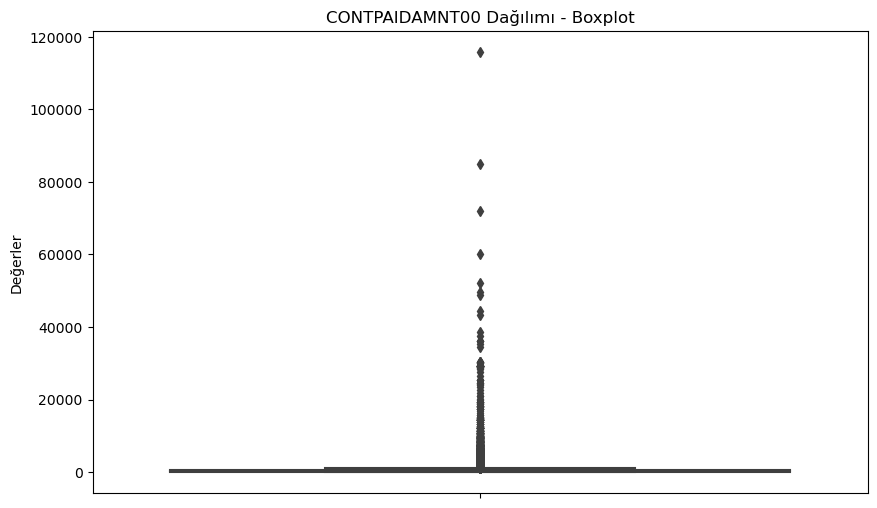

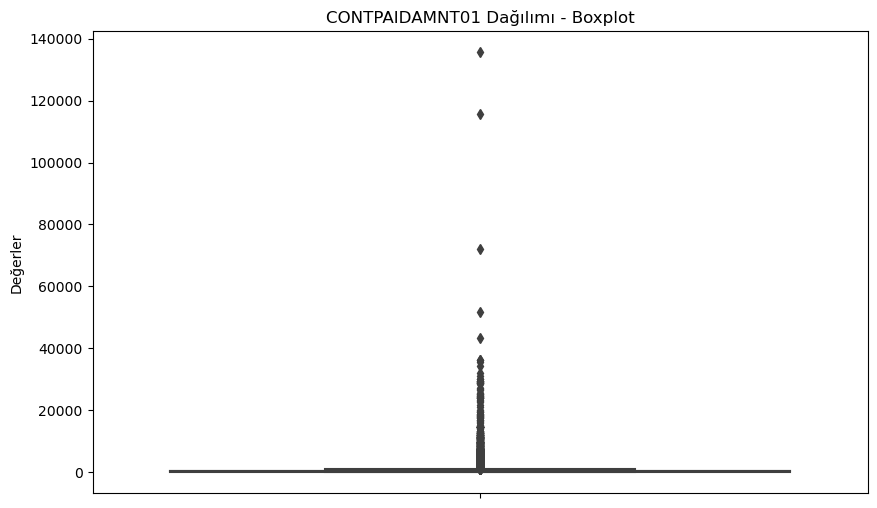

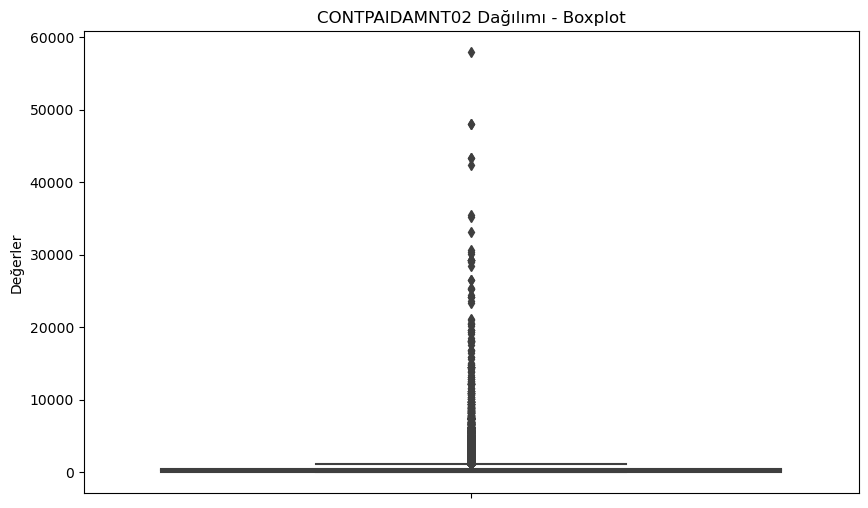

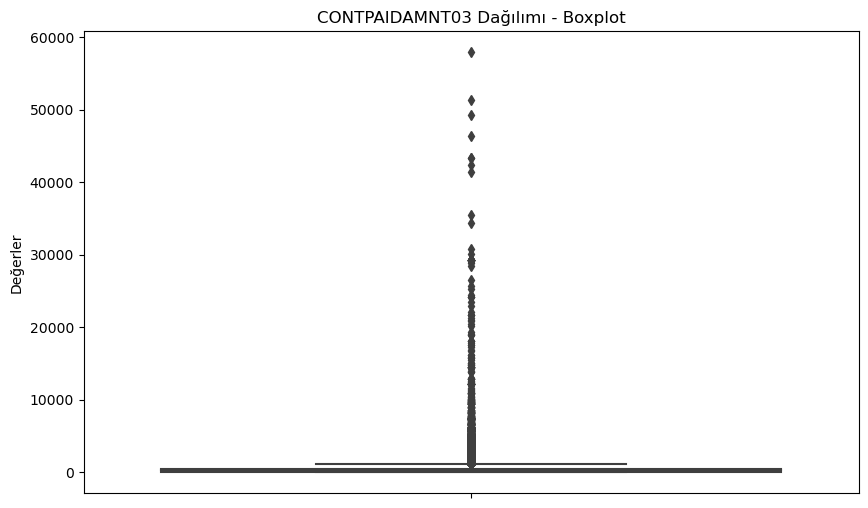

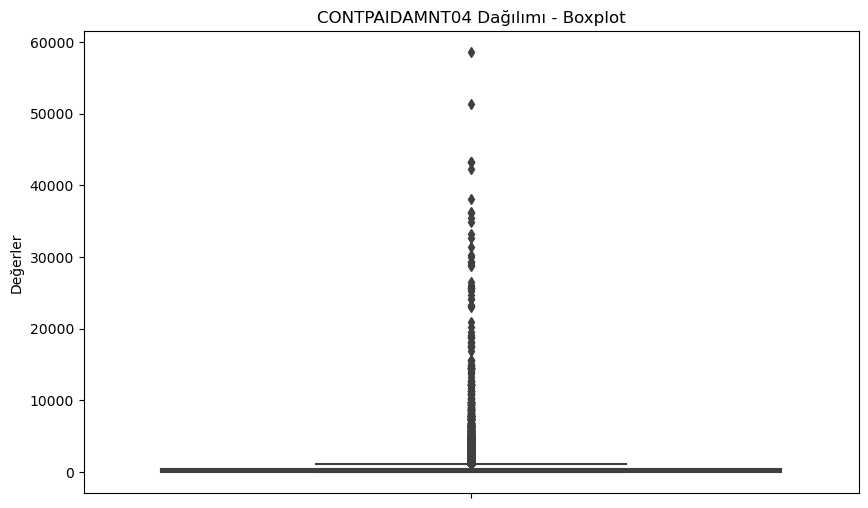

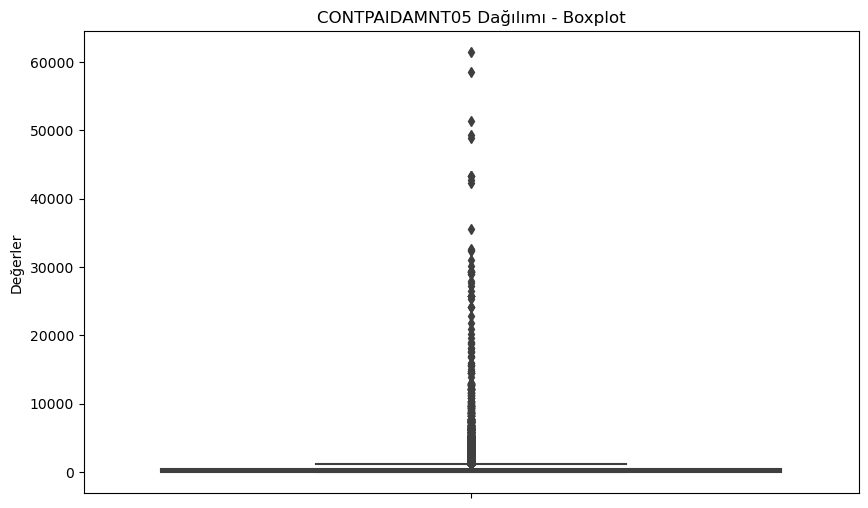

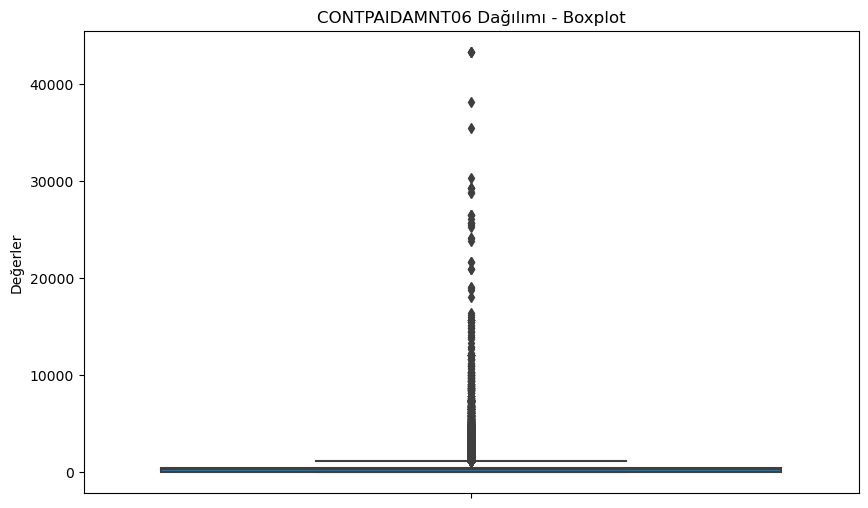

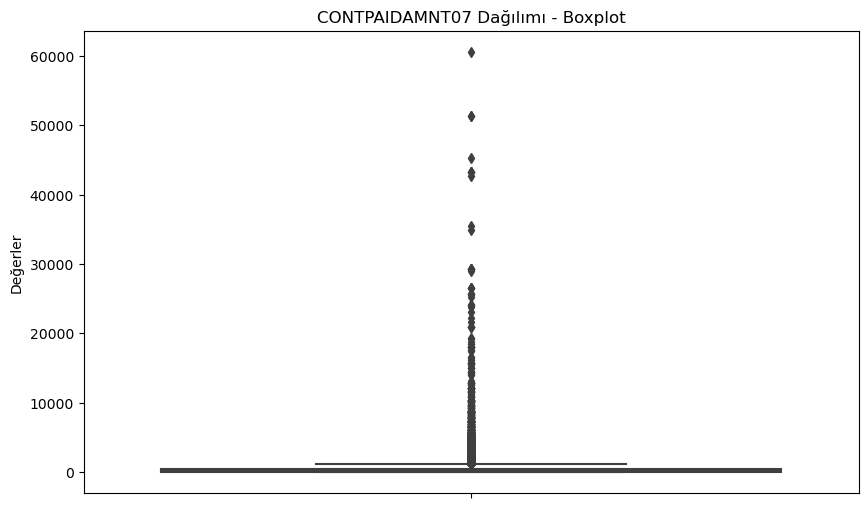

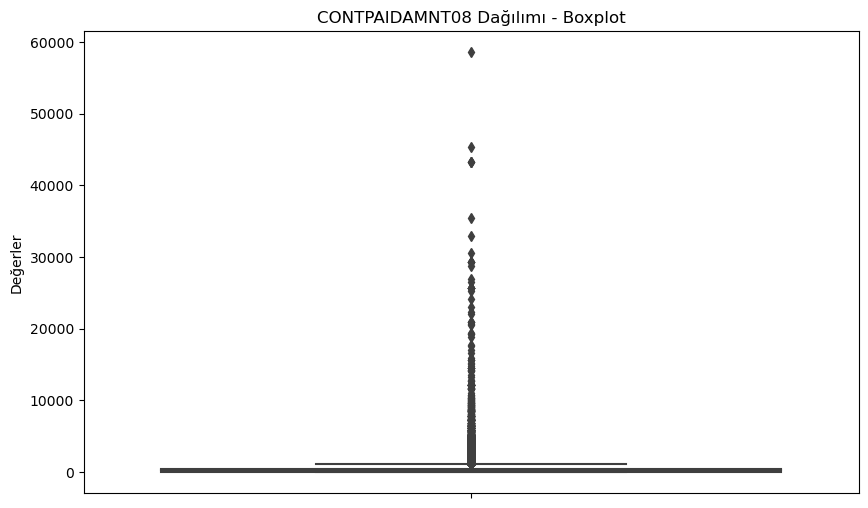

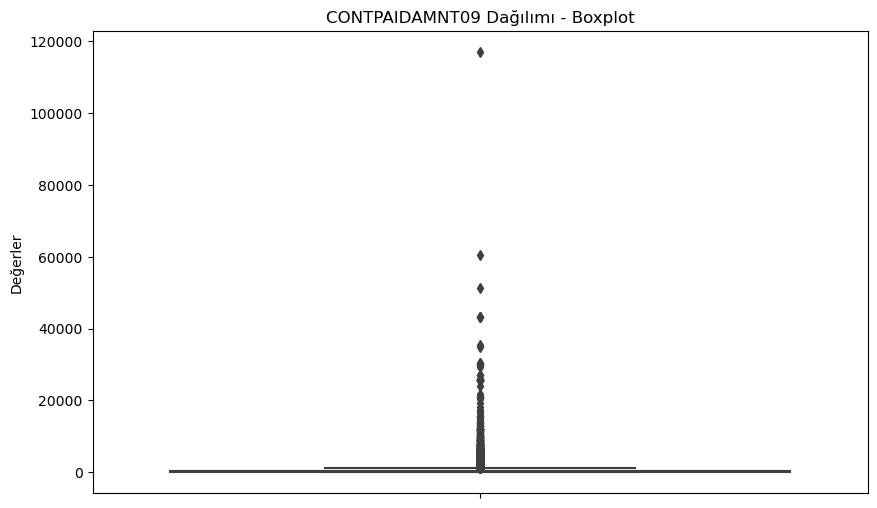

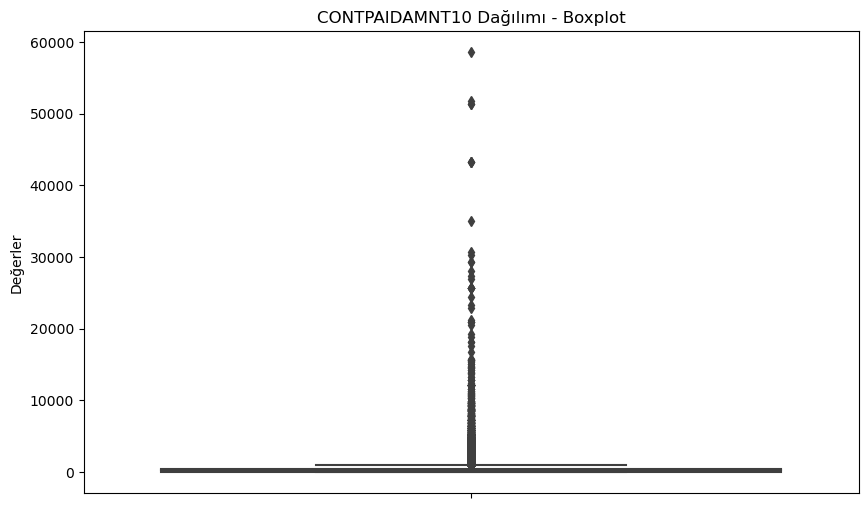

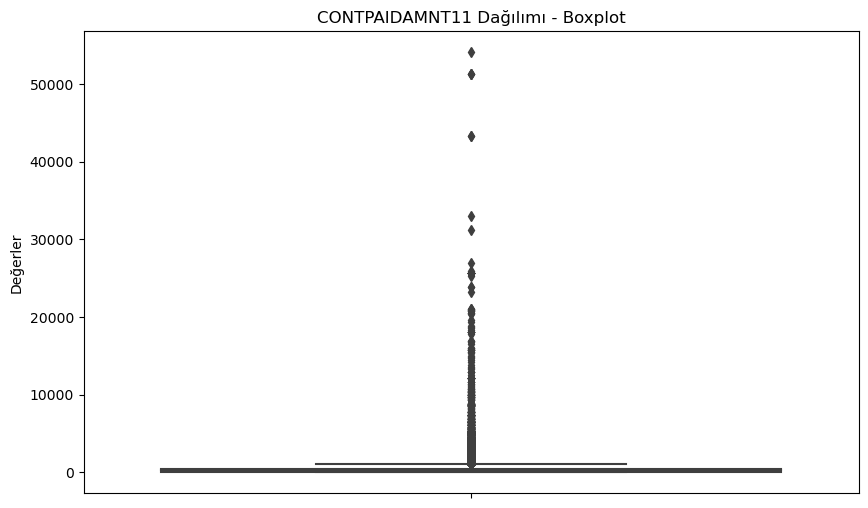

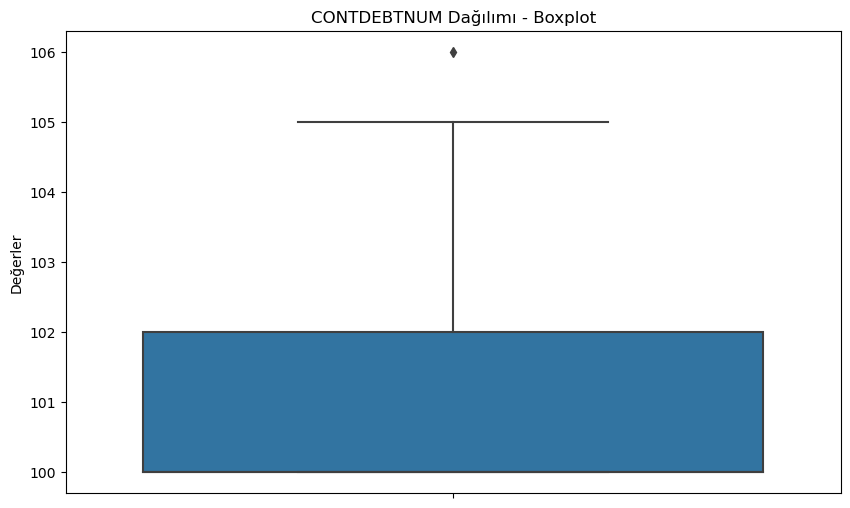

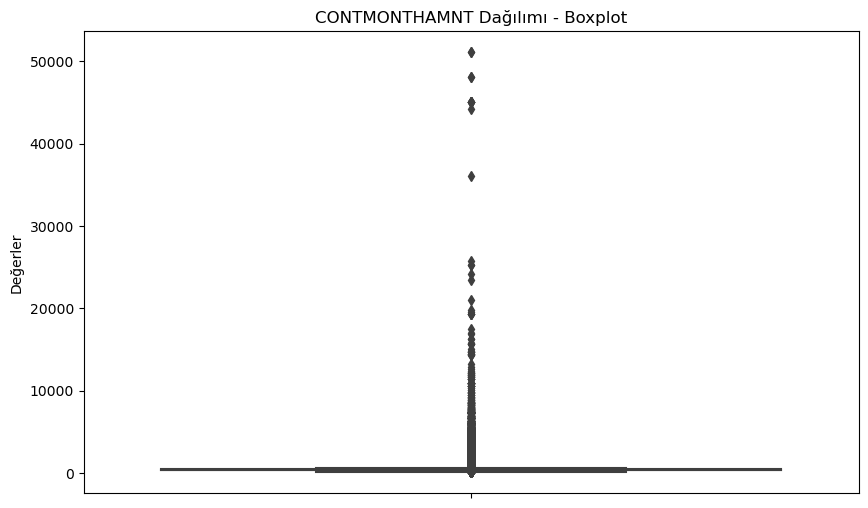

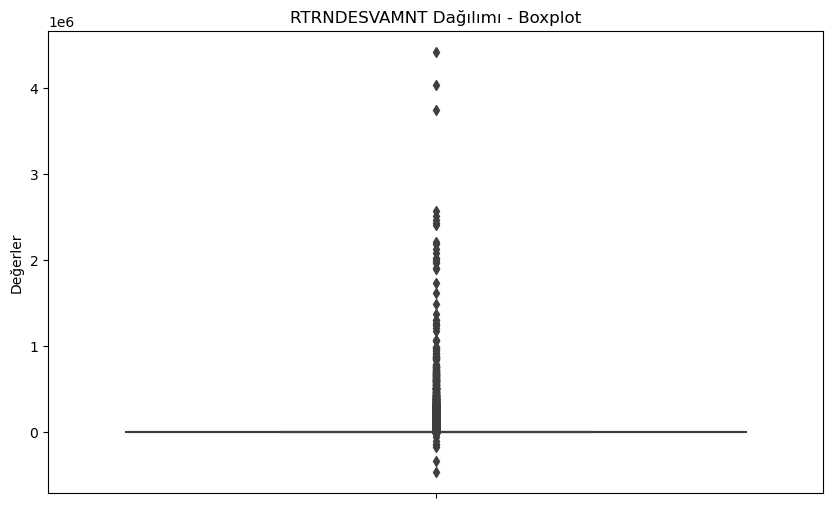

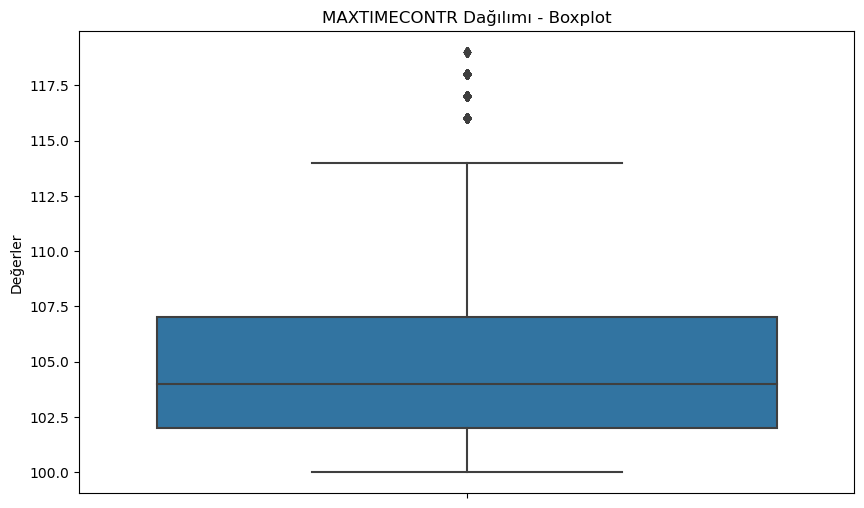

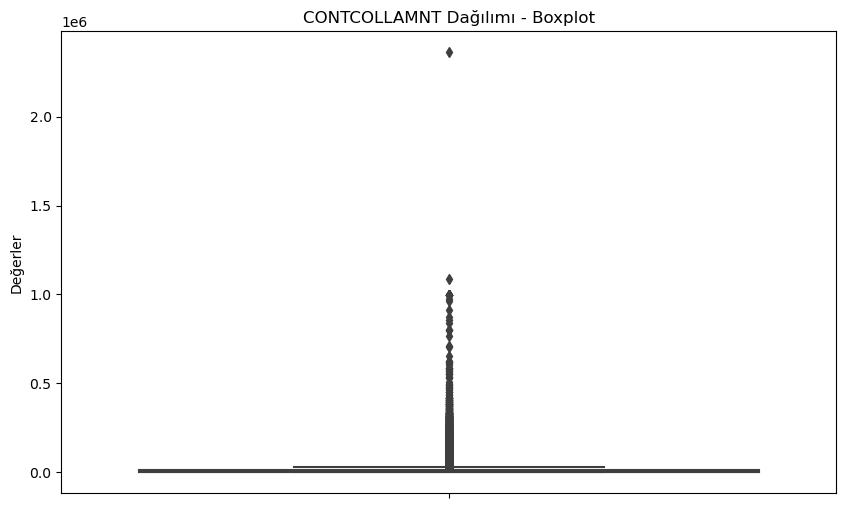

In [ ]:
for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(y=df[col])
    plt.title(f"{col} Dağılımı - Boxplot")
    plt.ylabel('Değerler')
    plt.show()

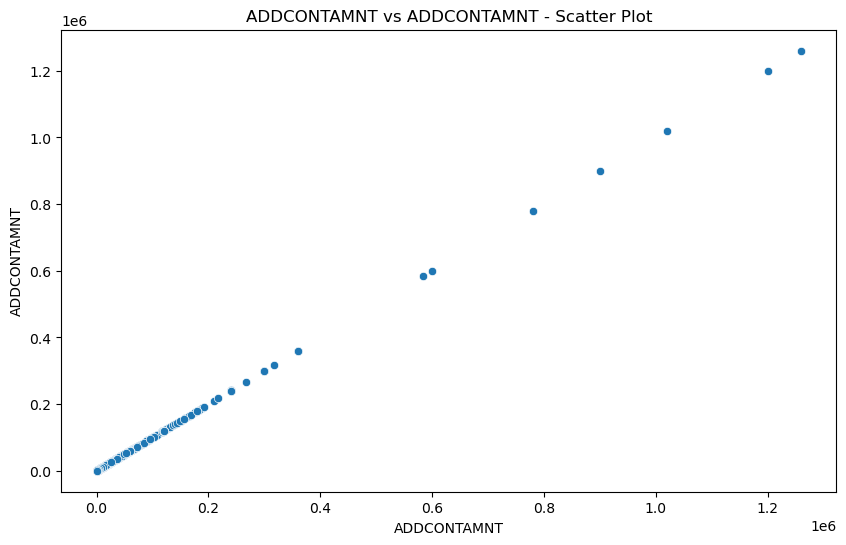

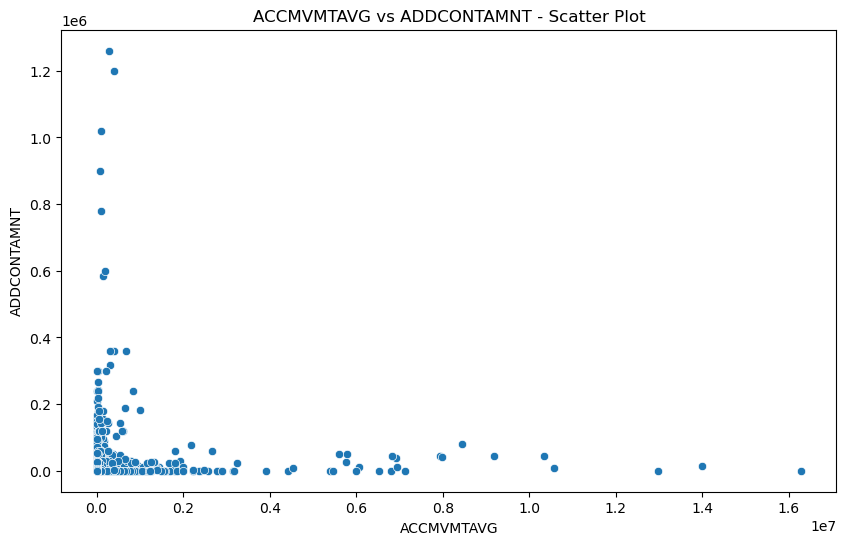

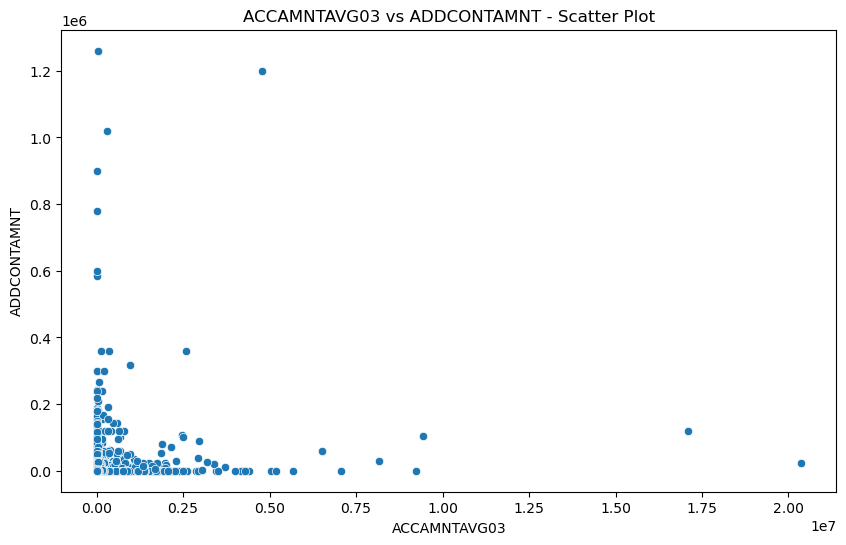

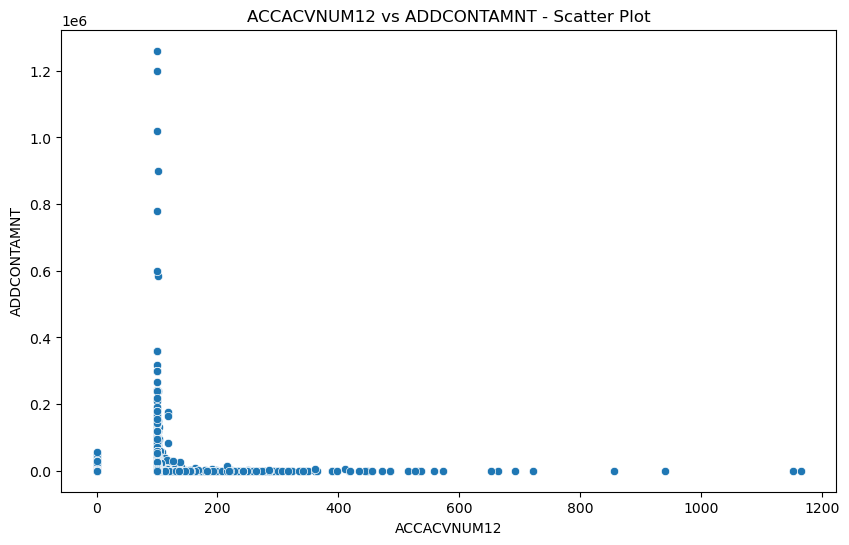

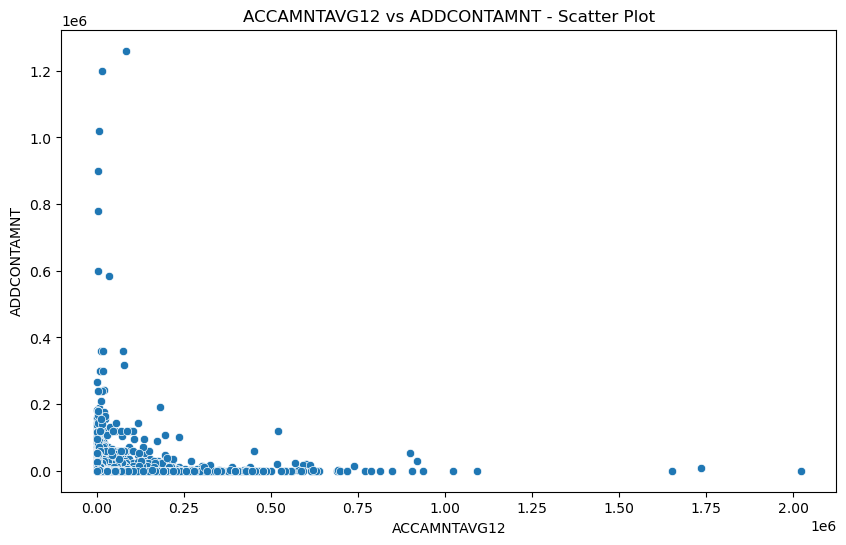

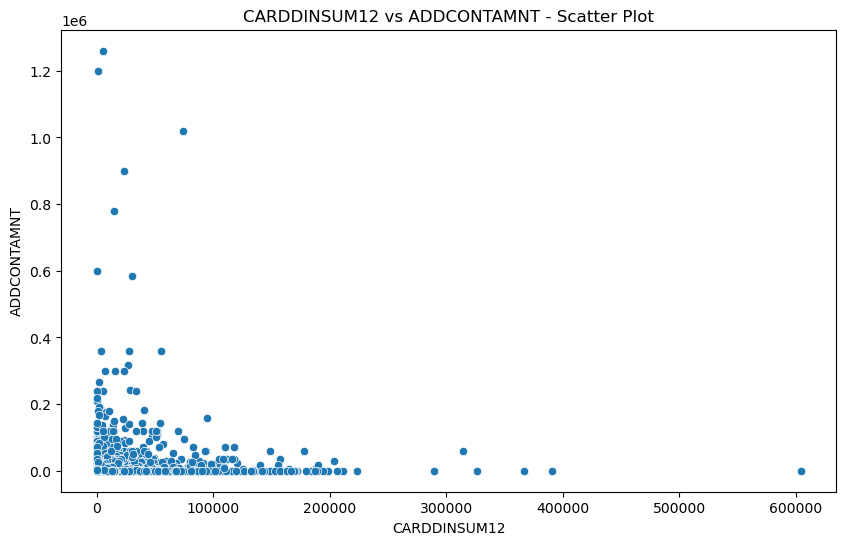

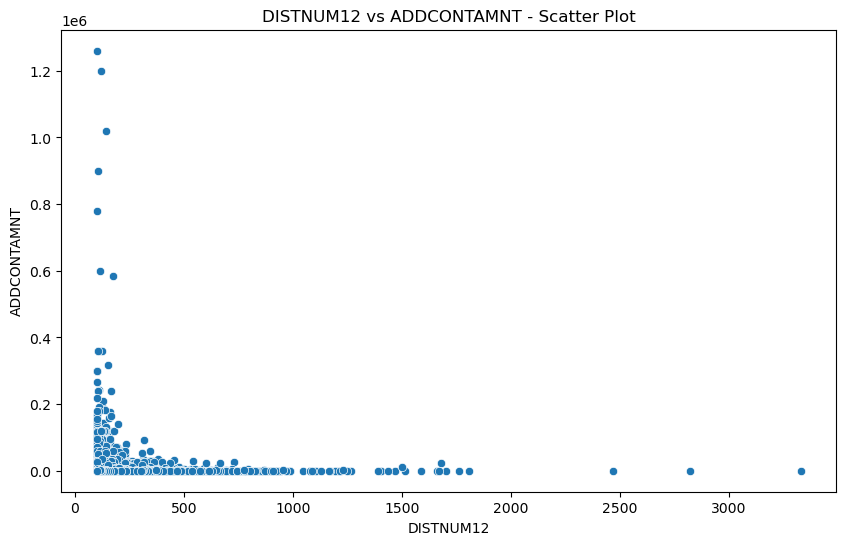

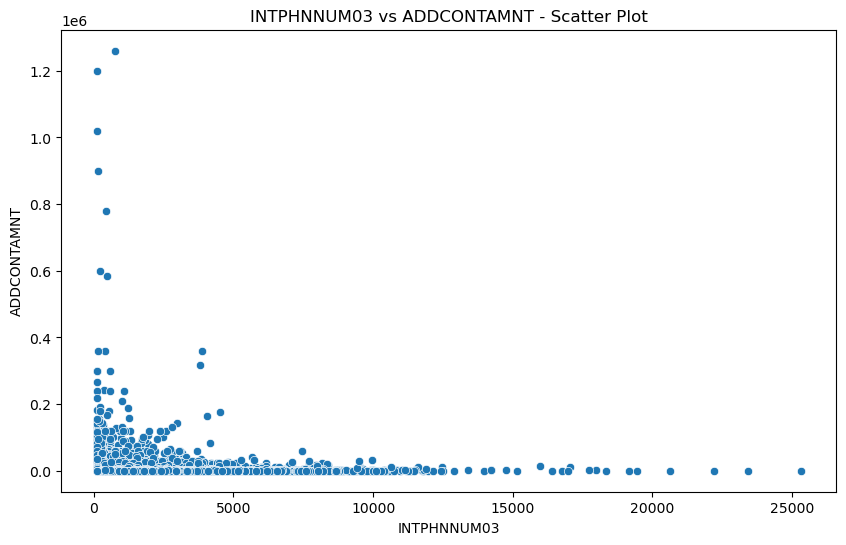

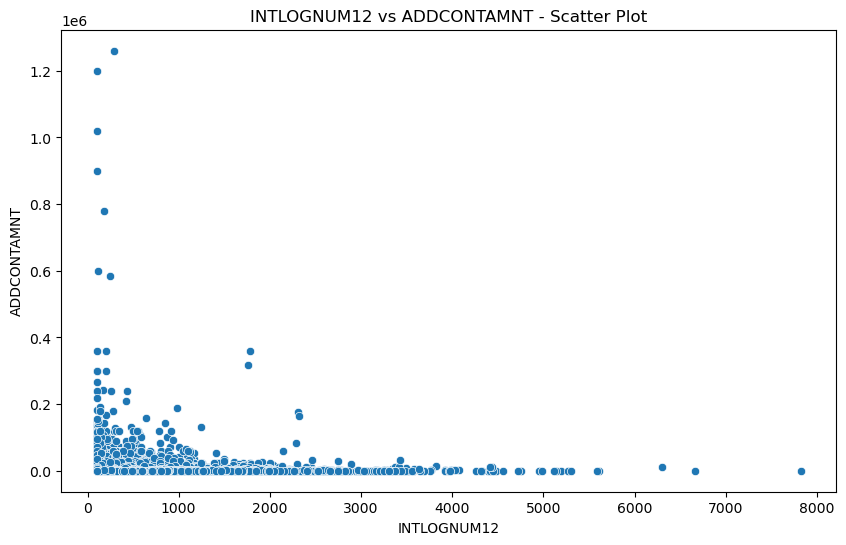

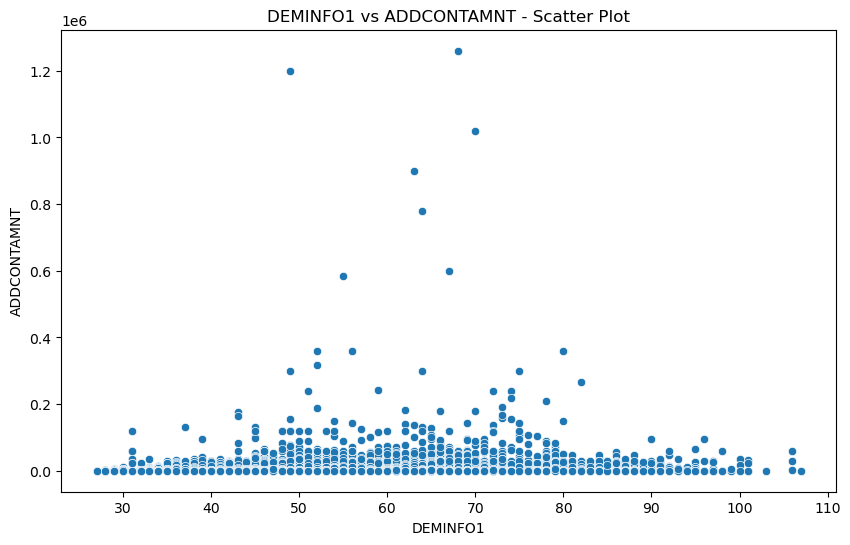

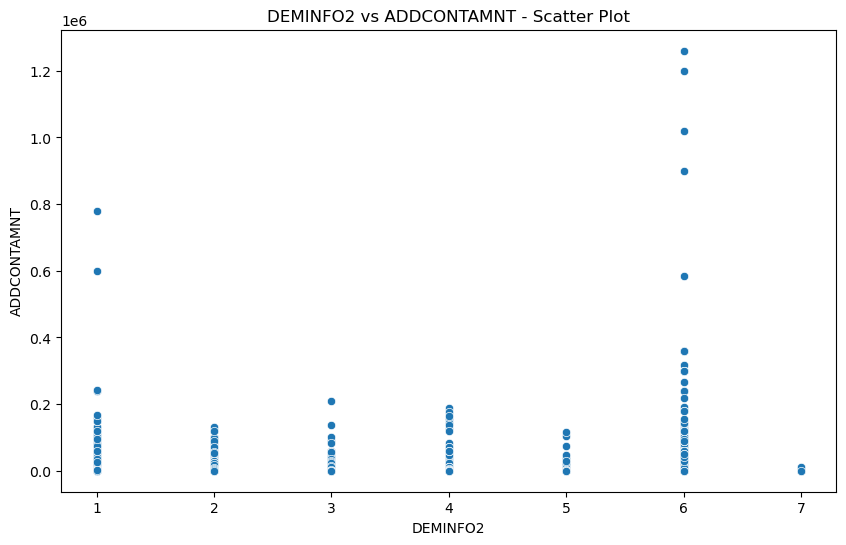

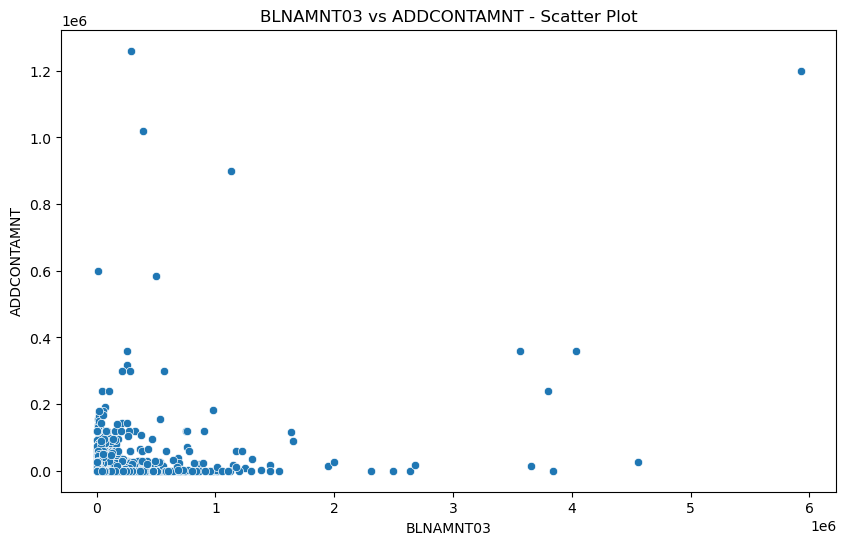

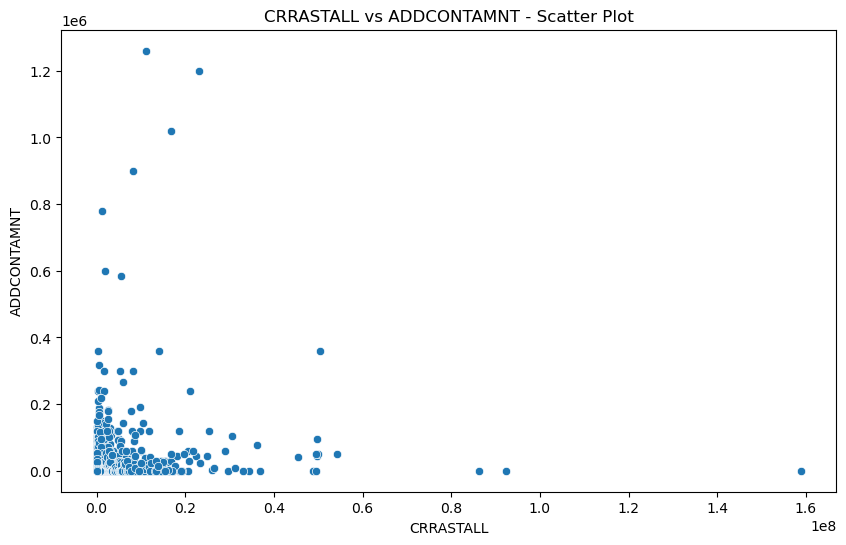

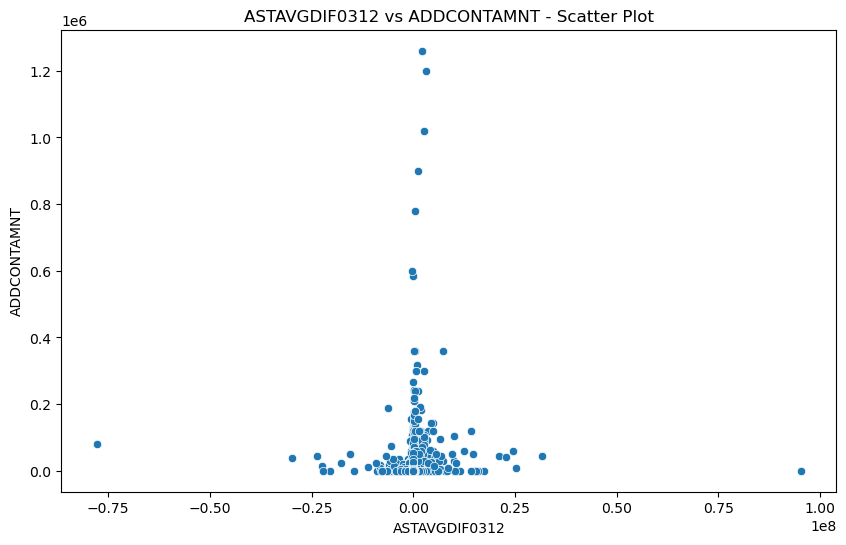

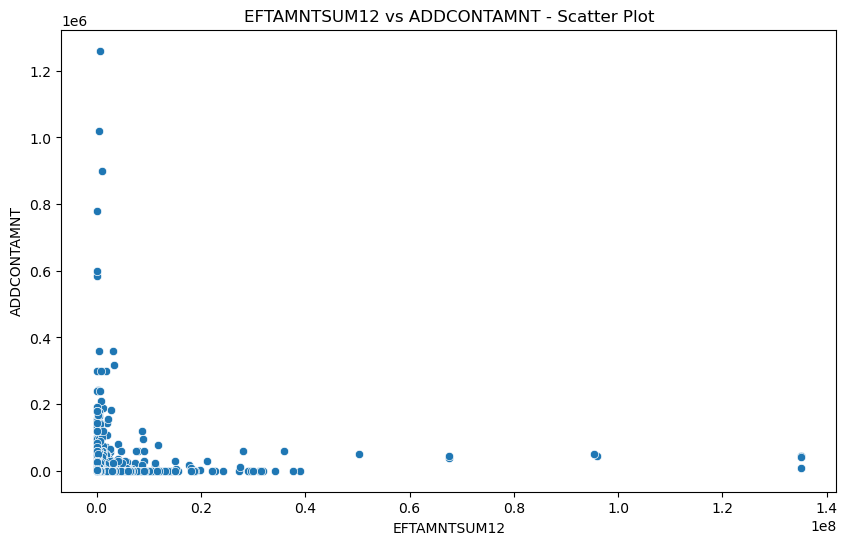

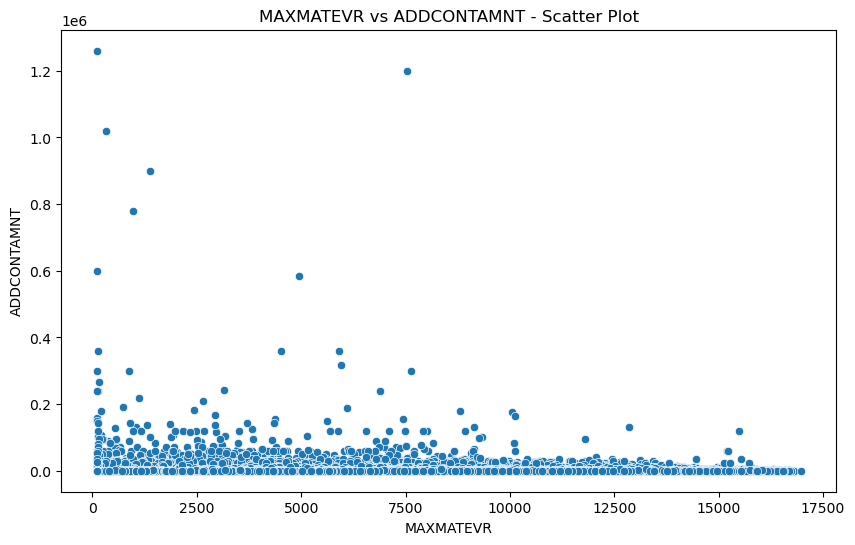

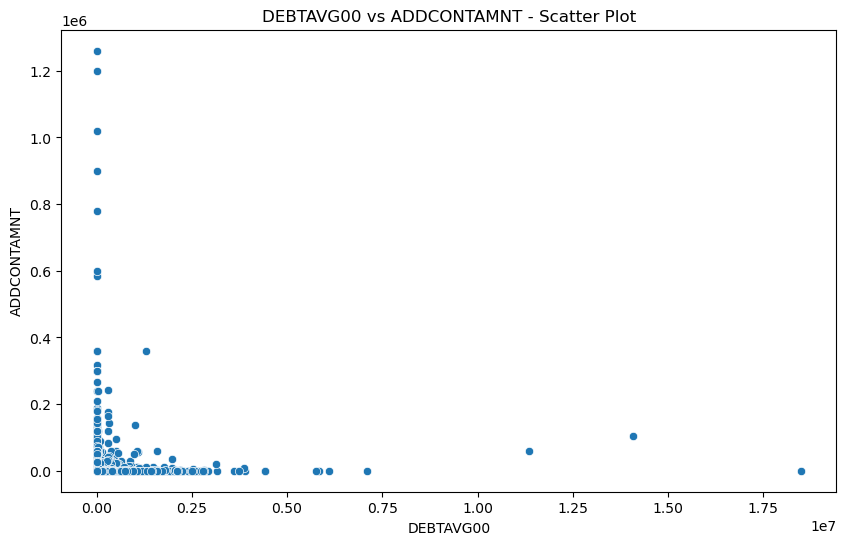

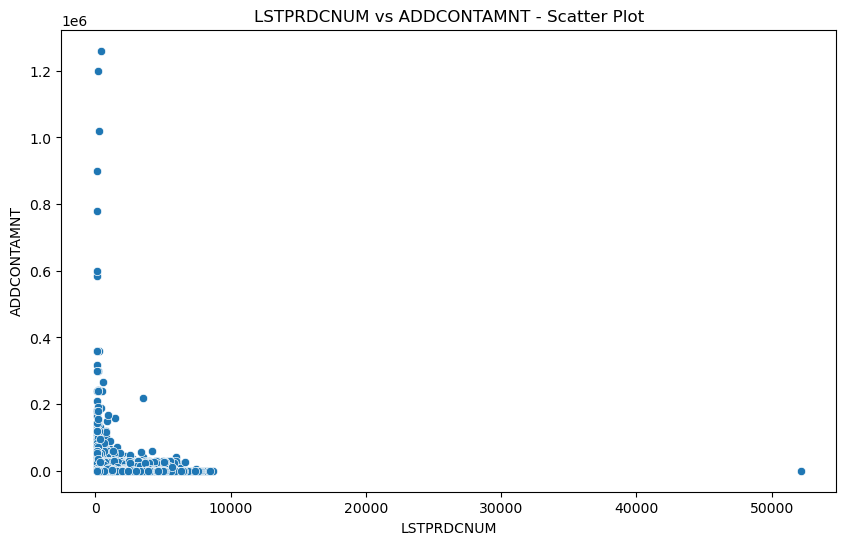

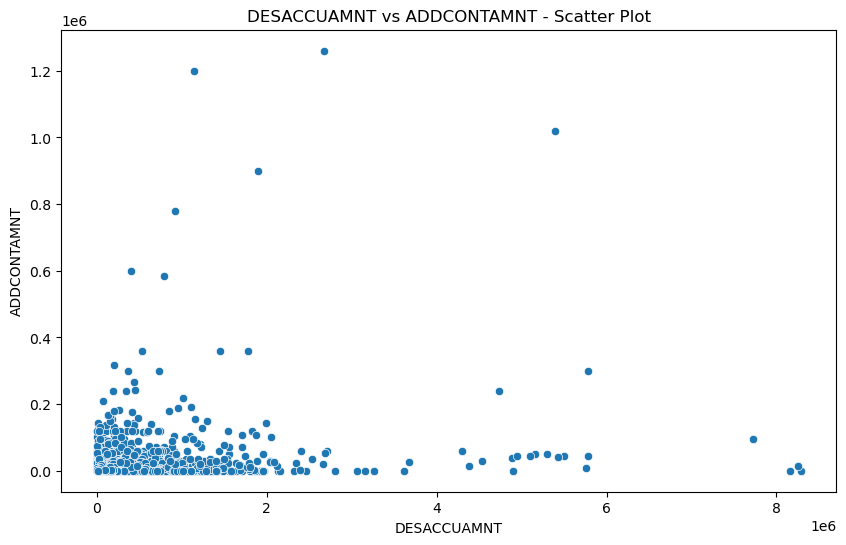

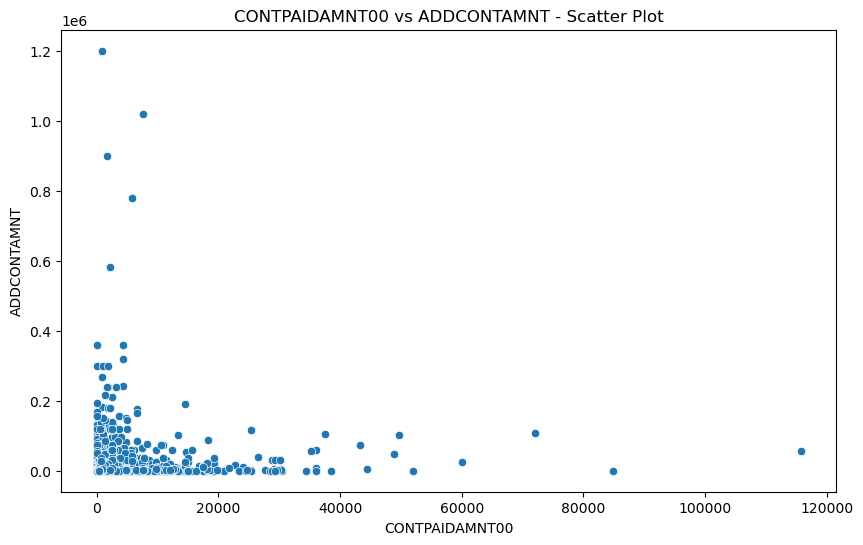

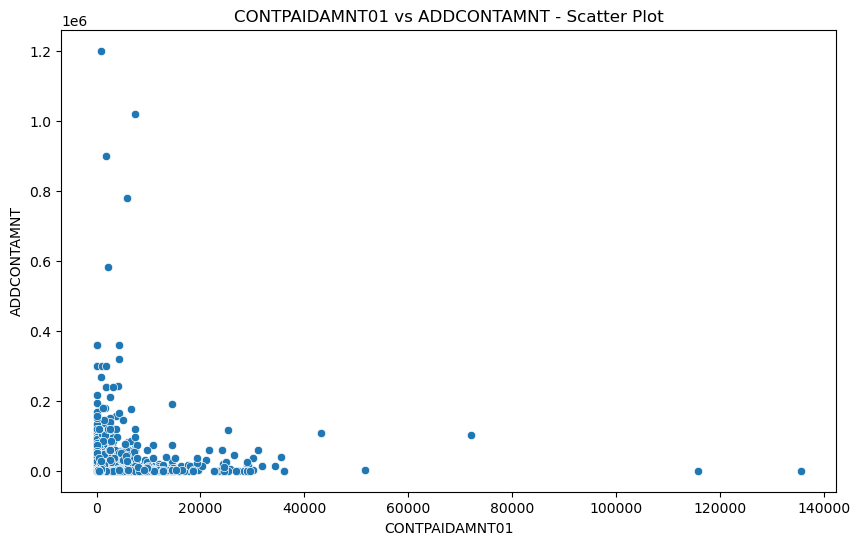

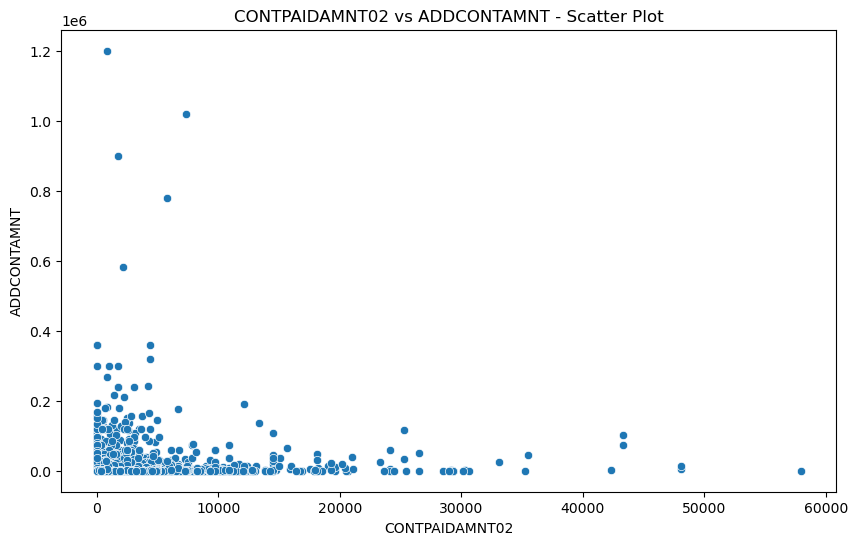

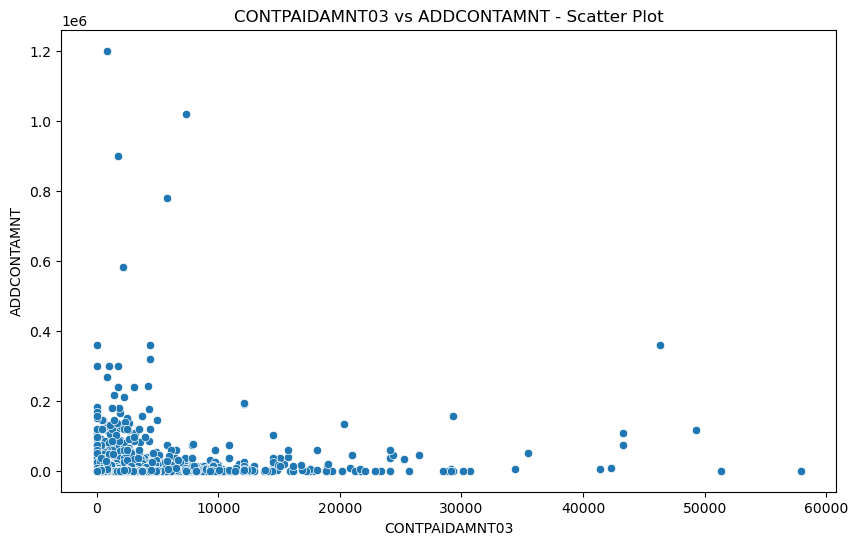

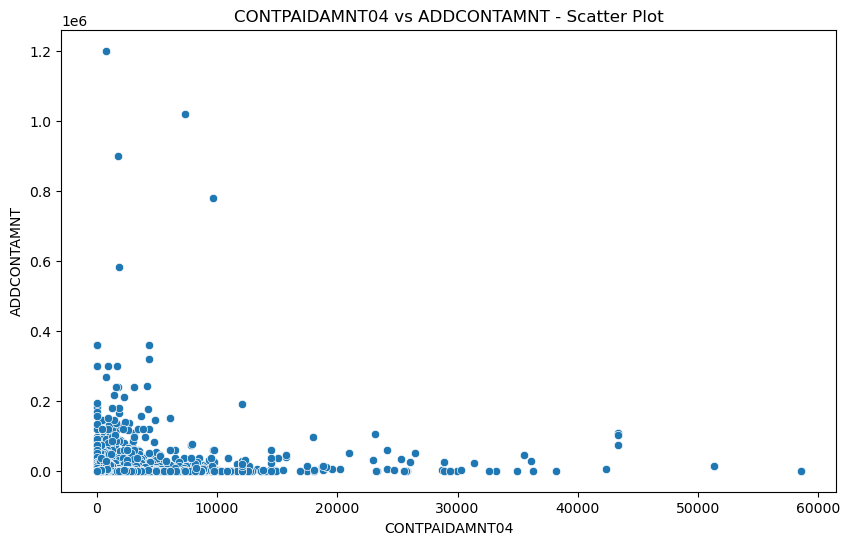

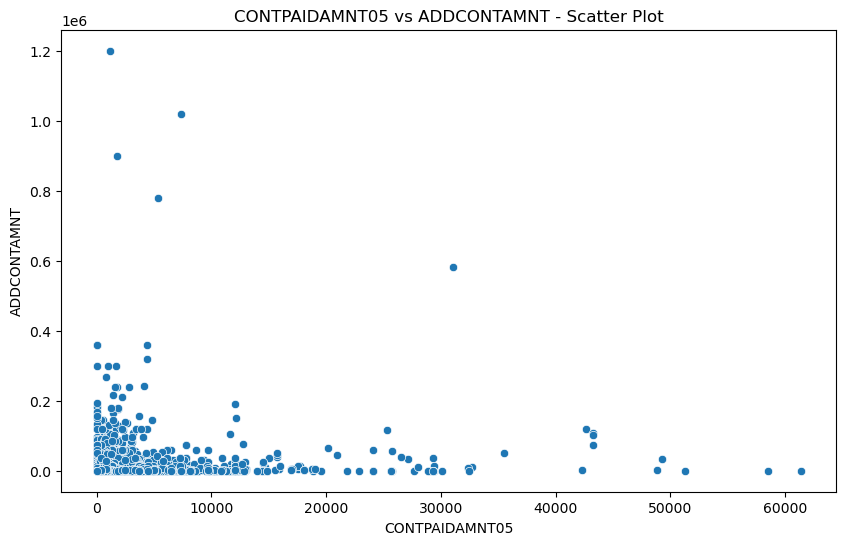

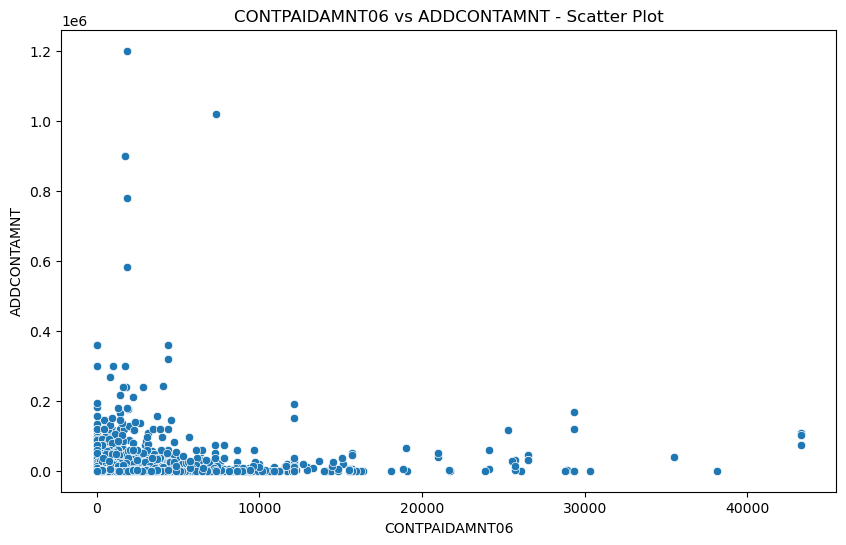

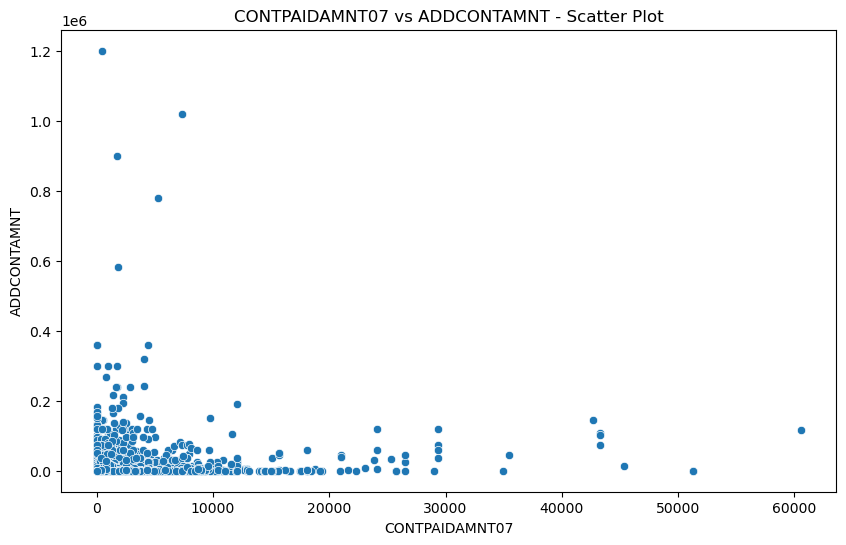

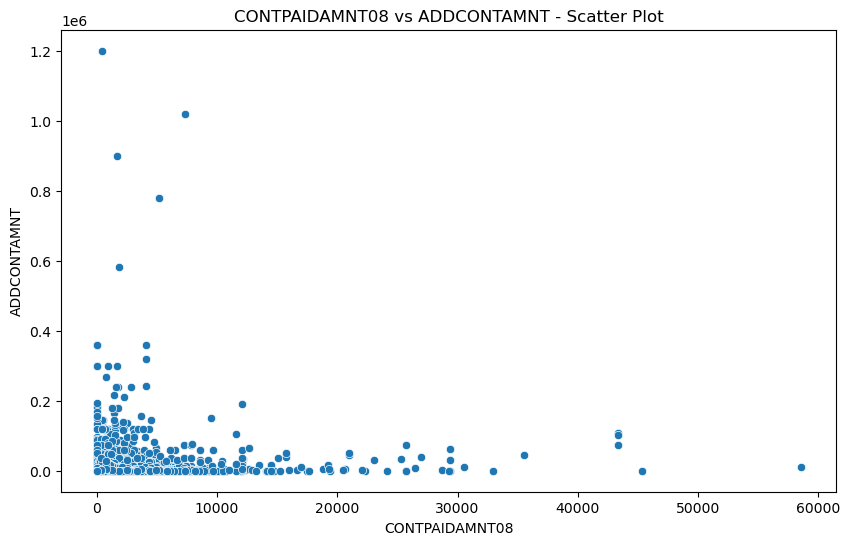

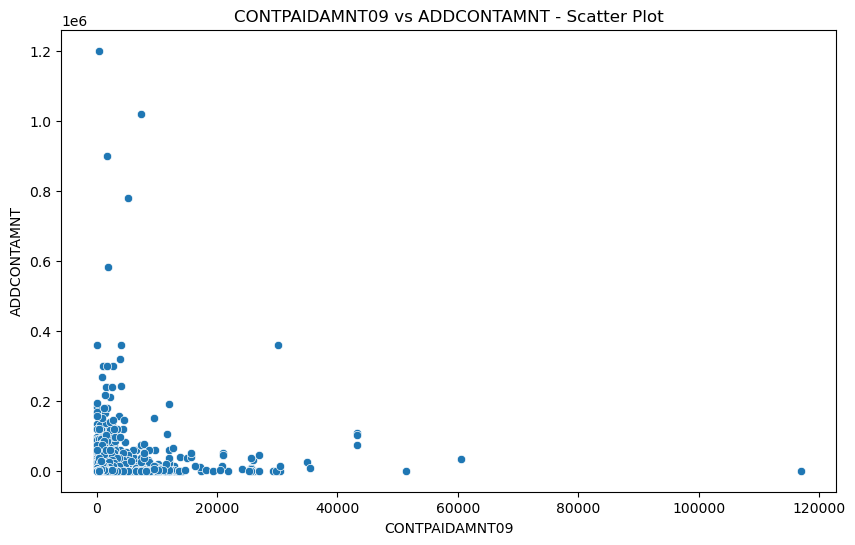

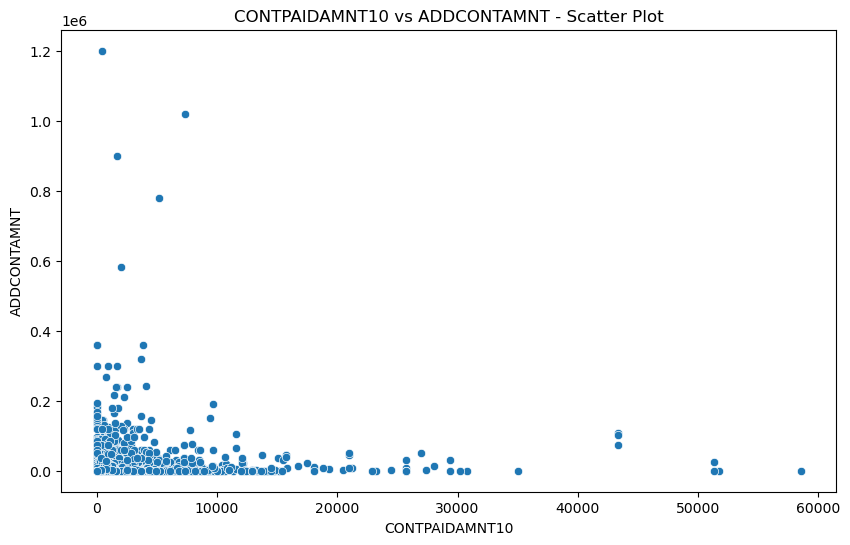

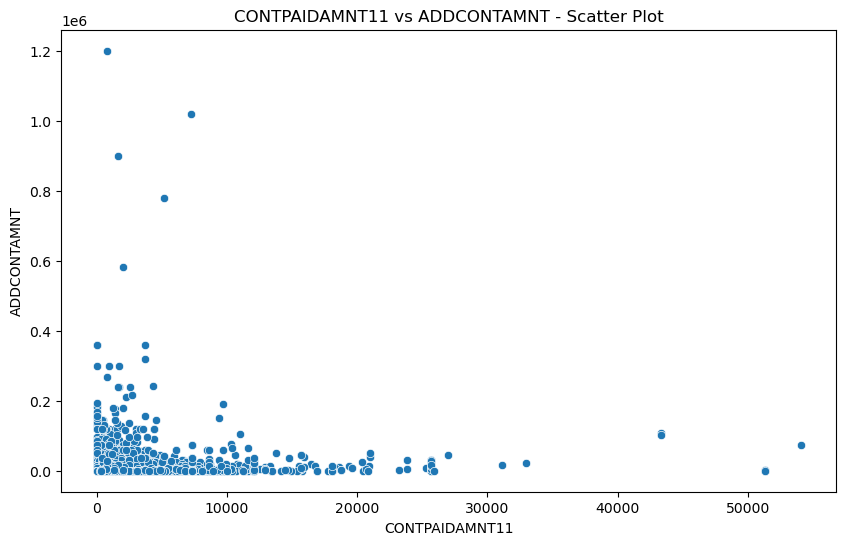

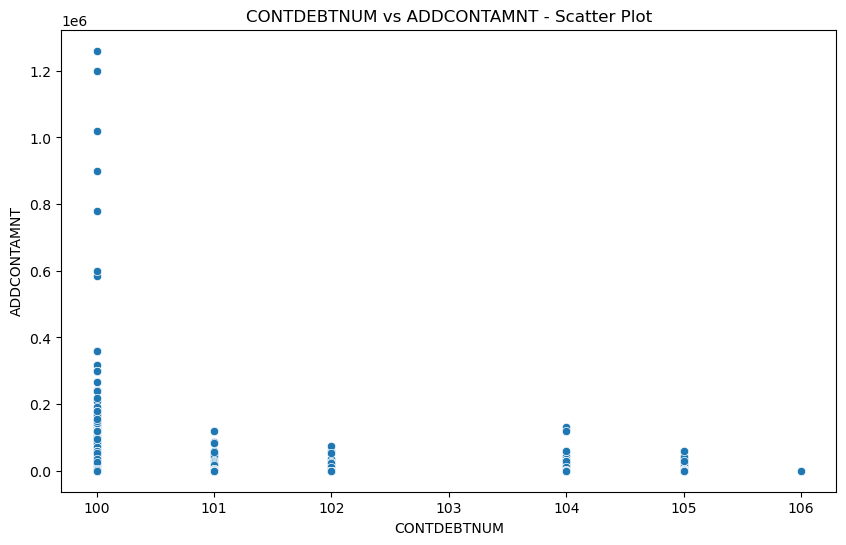

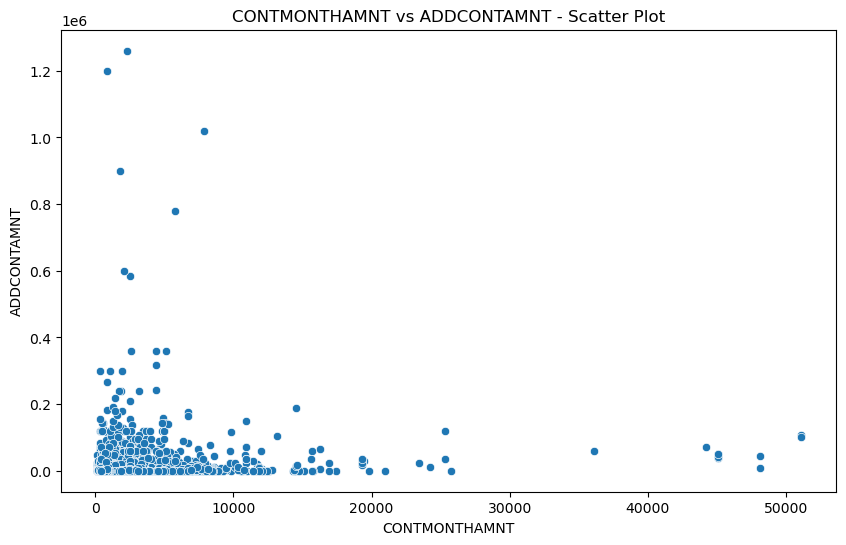

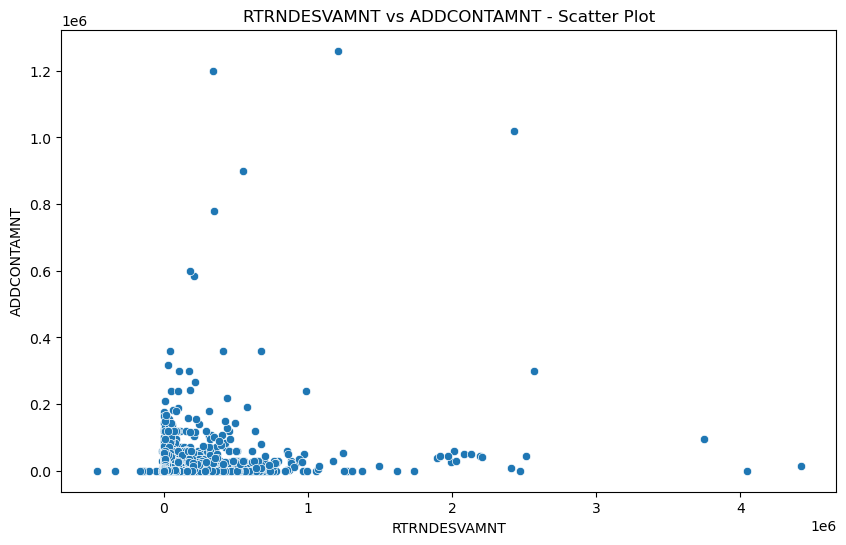

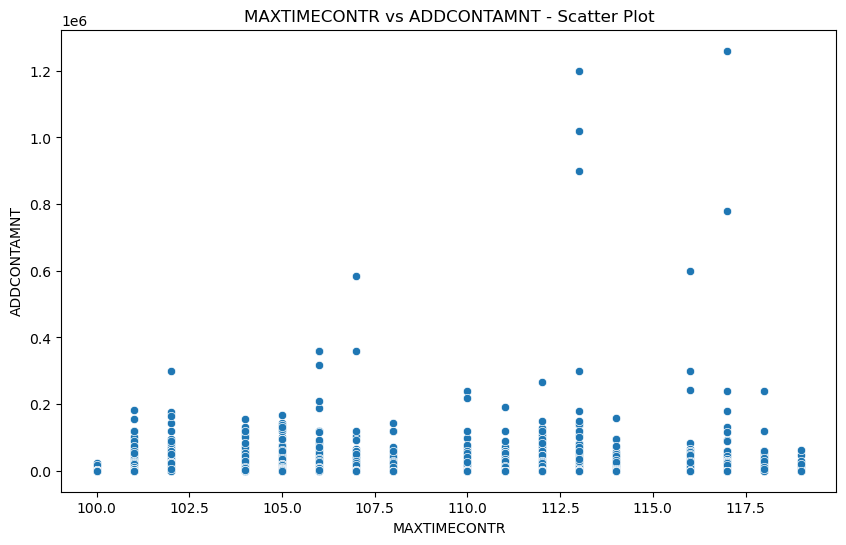

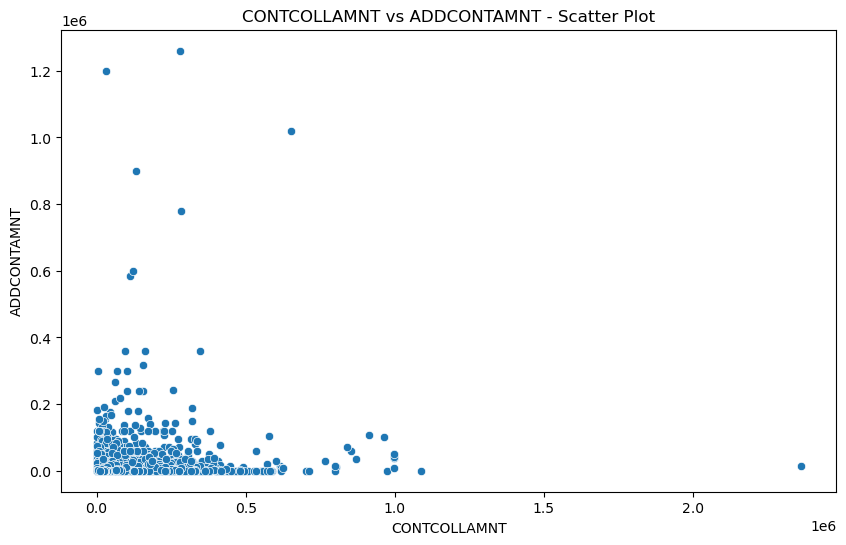

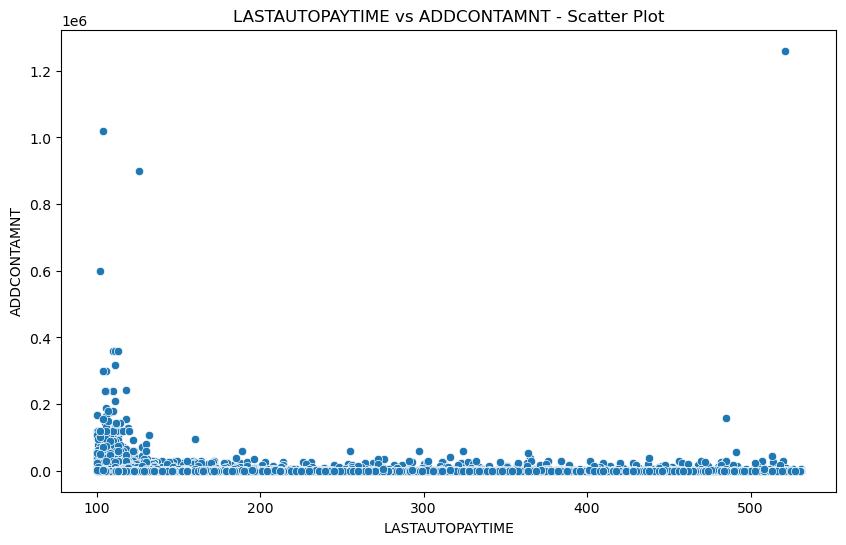

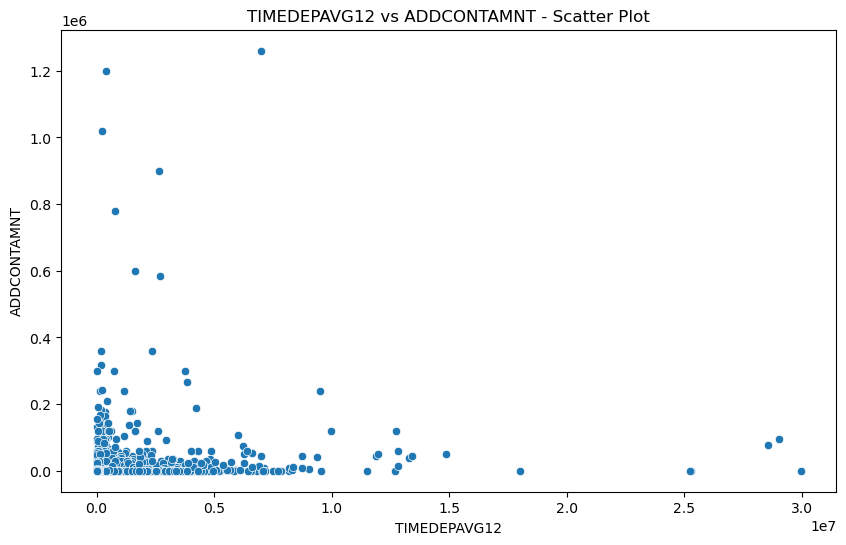

In [ ]:
for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df[col], y=df['ADDCONTAMNT'])
    plt.title(f"{col} vs ADDCONTAMNT - Scatter Plot")
    plt.xlabel(col)
    plt.ylabel('ADDCONTAMNT')
    plt.show()

In [ ]:
df["TRAN_DATE"].value_counts()

TRAN_DATE
2018-11-30    33790
2018-10-31    20230
2018-03-31    19180
2018-04-30    18469
2018-05-31    17520
2018-06-30    16380
2018-09-30    16330
2018-08-31    15890
2018-07-31    15800
Name: count, dtype: int64

In [ ]:
df.groupby("TRAN_DATE").agg({"ADDCONTAMNT":"mean",
                            "TRAN_DATE":"value_counts"}).sort_values(ascending=False,by="ADDCONTAMNT")

ADDCONTAMNT  TRAN_DATE
TRAN_DATE                         
2018-03-31  1105.998801      19180
2018-11-30   958.150695      33790
2018-04-30   867.773783      18469
2018-08-31   736.171617      15890
2018-05-31   735.381279      17520
2018-10-31   666.999605      20230
2018-06-30   625.370574      16380
2018-07-31   586.265823      15800
2018-09-30   533.366993      16330

In [ ]:
korelasyon = df[num_cols].corr()

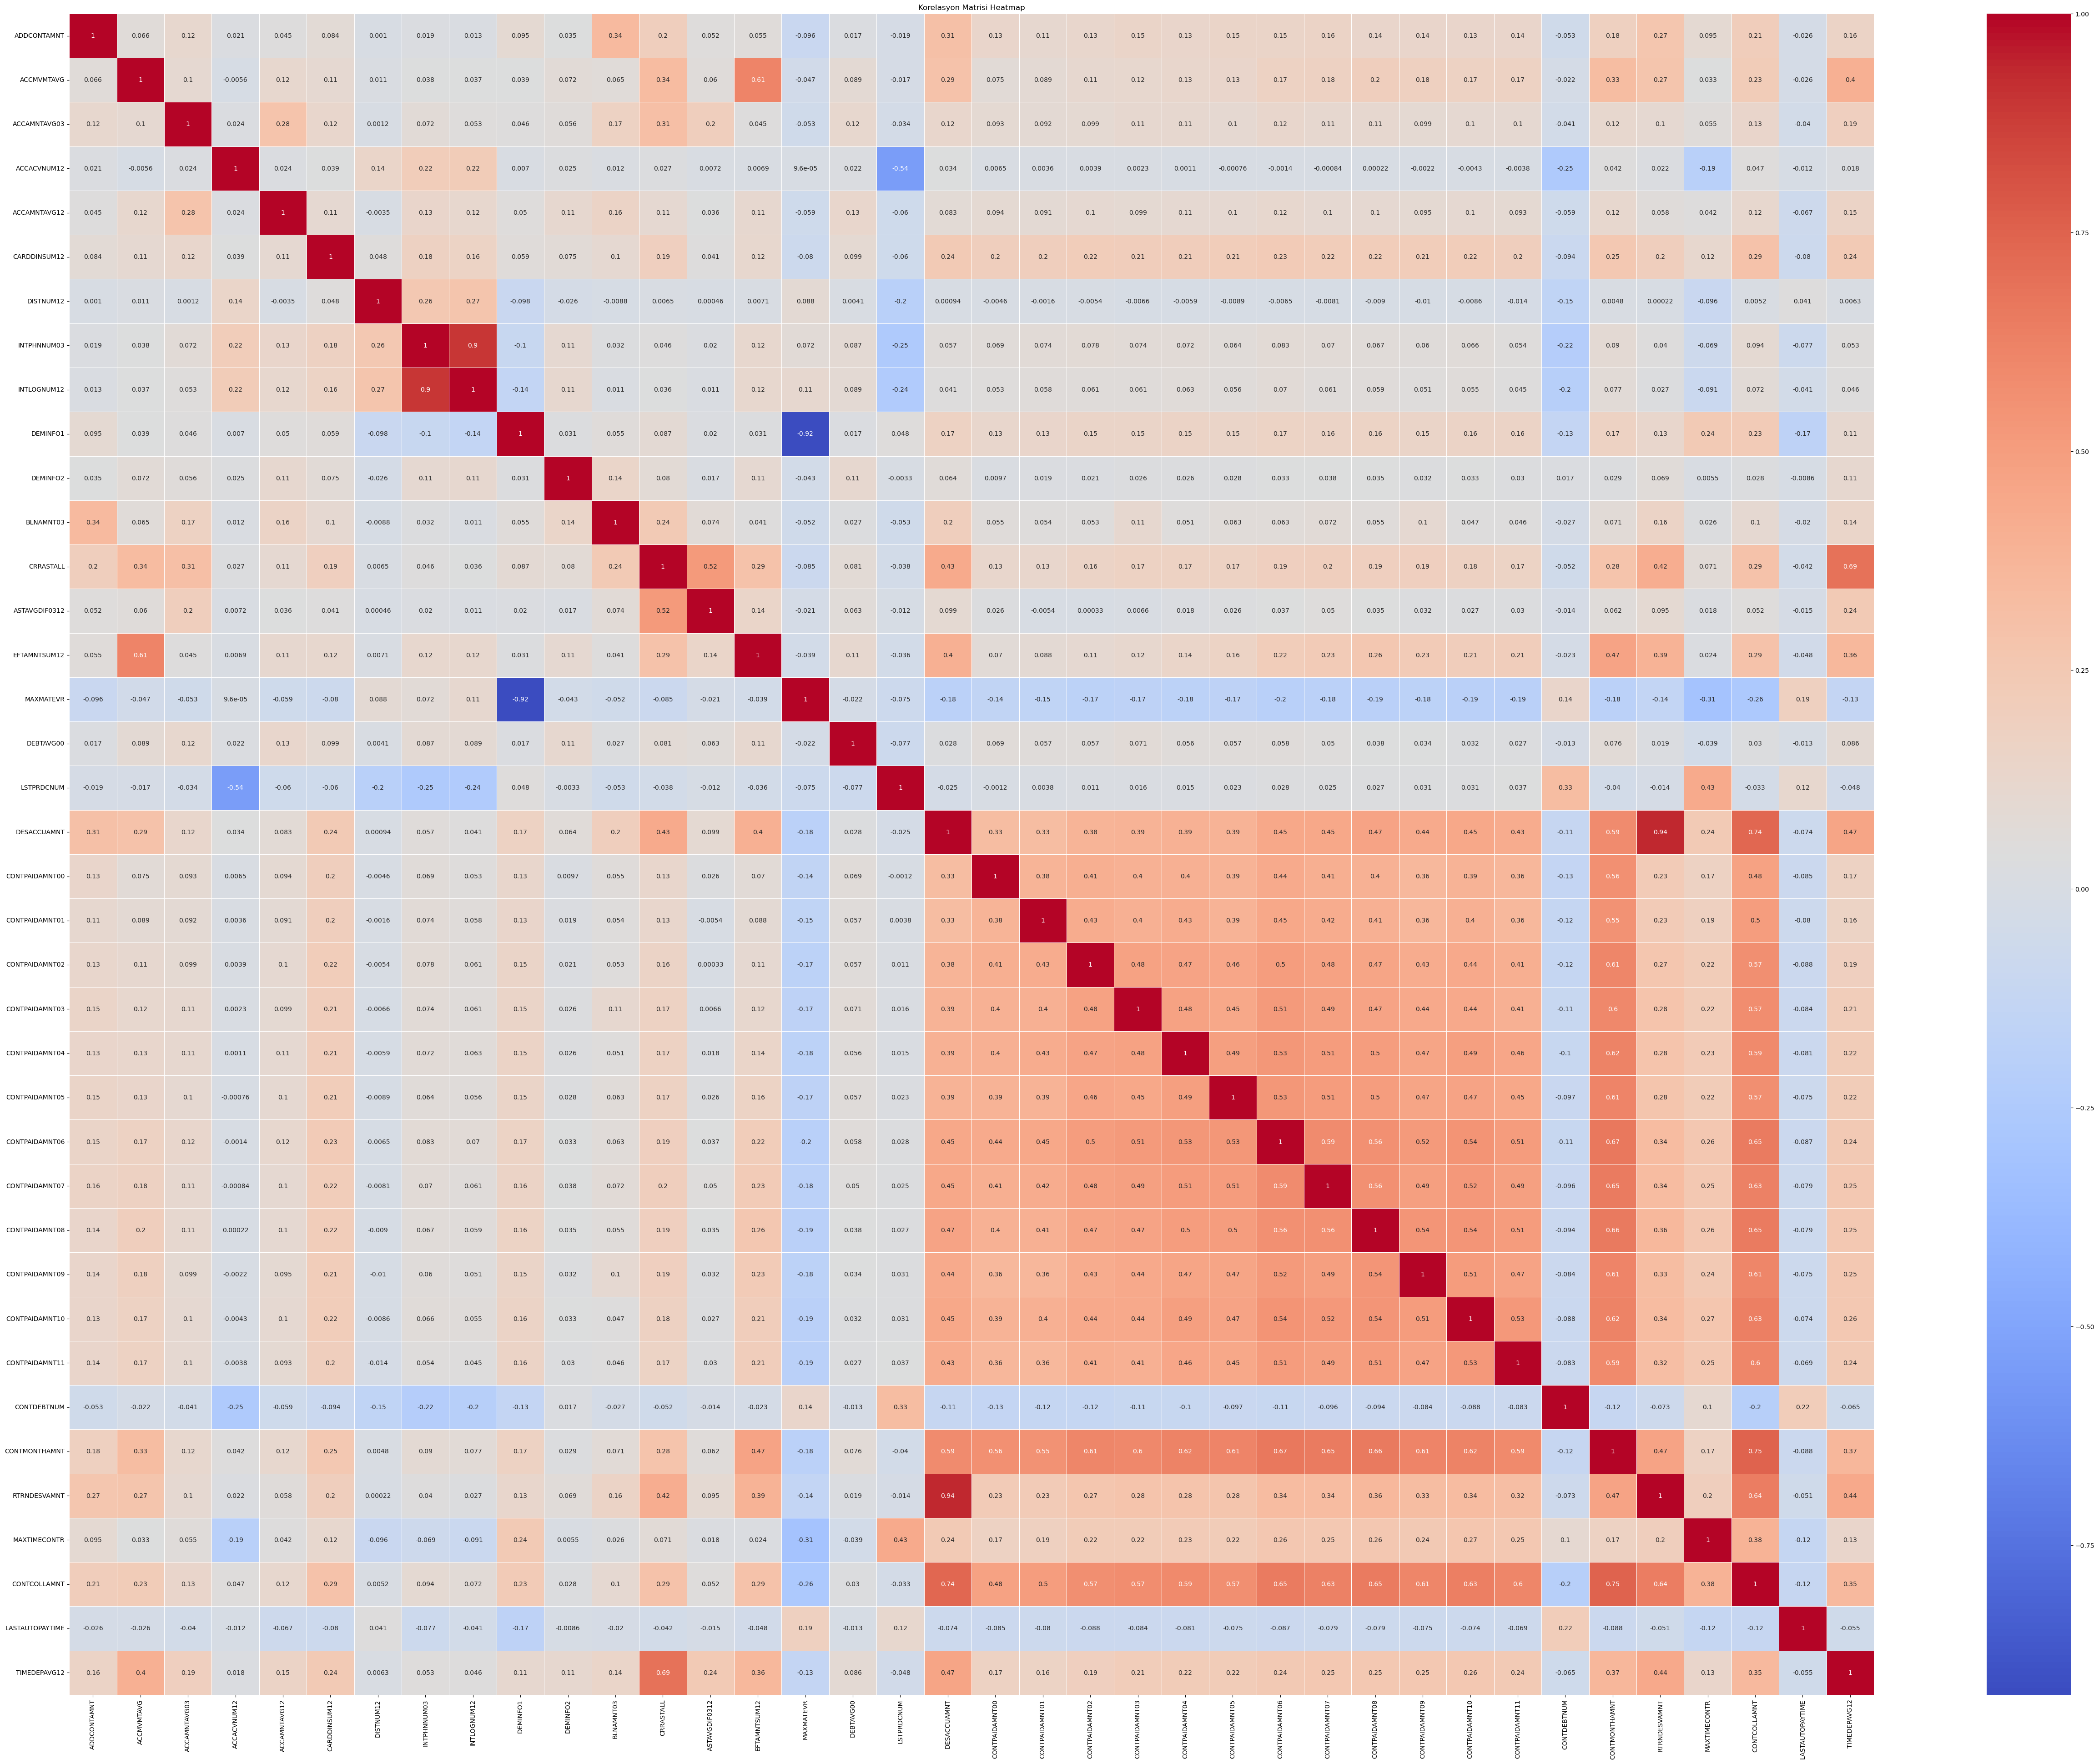

In [ ]:
plt.figure(figsize=(64, 48))
sns.heatmap(korelasyon, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Korelasyon Matrisi Heatmap')
plt.show()

In [ ]:
contpaid_cols = [col for col in df.columns if "CONTPAID" in col]
contpaid_cols.append("ADDCONTAMNT")
contpaid_korelasyon = df[contpaid_cols].corr()

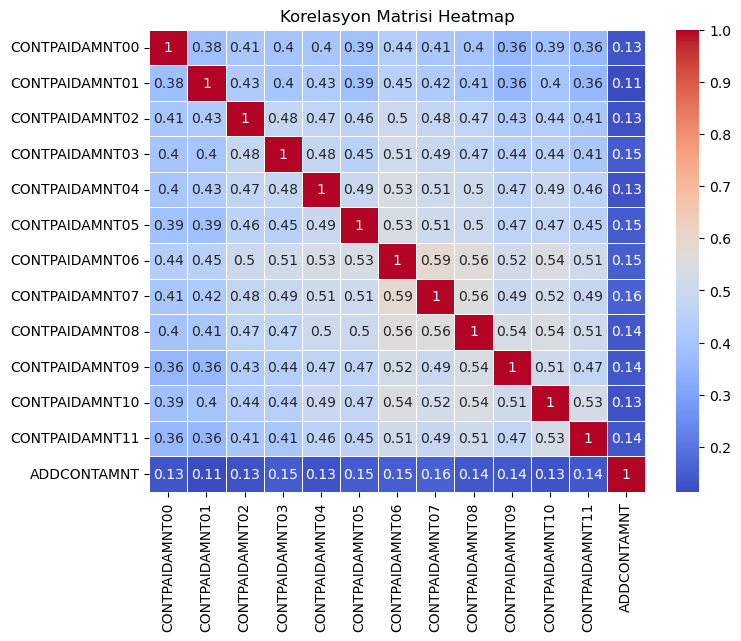

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(contpaid_korelasyon, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Korelasyon Matrisi Heatmap')
plt.show()

In [ ]:
df["DEMINFO2"].describe()

count    173589.000000
mean          2.148598
std           0.732367
min           1.000000
25%           2.000000
50%           2.000000
75%           2.000000
max           7.000000
Name: DEMINFO2, dtype: float64

In [ ]:
df.groupby("DEMINFO2")["ADDCONTAMNT"].describe().round(2).T

DEMINFO2          1          2          3          4          5           6  \
count      18893.00  124342.00   17740.00   11506.00     509.00      586.00   
mean        2810.28     341.86     466.02    1147.98    2929.91    29553.71   
std        11369.71    2466.29    3601.73    6304.78   10181.54   104013.83   
min            0.00       0.00       0.00       0.00       0.00        0.00   
25%            0.00       0.00       0.00       0.00       0.00        0.00   
50%            0.00       0.00       0.00       0.00       0.00     2500.00   
75%          402.00       0.00       0.00       0.00       0.00    24730.75   
max       780100.00  132100.00  210100.00  189340.00  117100.00  1260100.00   

DEMINFO2         7  
count        13.00  
mean       1518.46  
std        3731.04  
min           0.00  
25%           0.00  
50%           0.00  
75%           0.00  
max       11980.00

In [ ]:

df.groupby("CONTDEBTNUM")["ADDCONTAMNT"].describe().round(2).T


CONTDEBTNUM         100        101       102        104       105  106
count         115970.00   10363.00   3956.00   39308.00   3991.00  1.0
mean            1079.15     530.32    269.30      91.91    146.40  0.0
std             9539.49    3496.72   2583.74    1623.25   2127.17  NaN
min                0.00       0.00      0.00       0.00      0.00  0.0
25%                0.00       0.00      0.00       0.00      0.00  0.0
50%                0.00       0.00      0.00       0.00      0.00  0.0
75%                0.00       0.00      0.00       0.00      0.00  0.0
max          1260100.00  120100.00  73540.00  132100.00  58900.00  0.0

In [ ]:
df["MAXTIMECONTR"].describe()

count    173589.000000
mean        105.411046
std           4.112570
min         100.000000
25%         102.000000
50%         104.000000
75%         107.000000
max         119.000000
Name: MAXTIMECONTR, dtype: float64

In [ ]:
df["MAXTIMECONTR"].value_counts()

MAXTIMECONTR
102    30533
101    29763
104    27771
105    17589
107    14452
106    14320
108     7298
110     6079
112     5322
111     5314
113     5166
114     4269
116     3020
117     1762
118      845
100       62
119       24
Name: count, dtype: int64

In [ ]:
df.groupby("MAXTIMECONTR")["ADDCONTAMNT"].describe().round(2).T

MAXTIMECONTR       100        101        102        104        105        106  \
count            62.00   29763.00   30533.00   27771.00   17589.00   14320.00   
mean            976.13     330.91     276.71     388.20     548.77     692.66   
std            3921.49    2985.06    3313.58    3342.14    4272.87    6703.78   
min               0.00       0.00       0.00       0.00       0.00       0.00   
25%               0.00       0.00       0.00       0.00       0.00       0.00   
50%               0.00       0.00       0.00       0.00       0.00       0.00   
75%               0.00       0.00       0.00       0.00       0.00       0.00   
max           24100.00  182200.00  300100.00  156100.00  168100.00  360100.00   

MAXTIMECONTR        107        108        110        111        112  \
count          14452.00    7298.00    6079.00    5314.00    5322.00   
mean             757.72     742.84    1015.03    1178.04    1990.25   
std             6896.00    4541.09    6335.35    5754.39    8169.17   
min                0.00       0.00       0.00       0.00       0.00   
25%                0.00       0.00       0.00       0.00       0.00   
50%                0.00       0.00       0.00       0.00       0.00   
75%                0.00       0.00       0.00       0.00       0.00   
max           583300.00  144100.00  240100.00  192100.00  267220.00   

MAXTIMECONTR         113        114        116         117        118  \
count            5166.00    4269.00    3020.00     1762.00     845.00   
mean             3234.95    2006.47    3006.20     4716.02    5659.56   
std             27104.41    6955.25   14818.93    37007.54   13638.89   
min                 0.00       0.00       0.00        0.00       0.00   
25%                 0.00       0.00       0.00        0.00       0.00   
50%                 0.00       0.00       0.00        0.00       0.00   
75%                 0.00       0.00       0.00      700.00    5333.00   
max           1200100.00  157300.00  600100.00  1260100.00  240100.00   

MAXTIMECONTR       119  
count            24.00  
mean          14790.17  
std           16354.46  
min               0.00  
25%               0.00  
50%           14500.00  
75%           23500.00  
max           61840.00

In [ ]:
df.isnull().sum() / df.shape[0] * 100

CUSTNBR             0.000000
TRAN_DATE           0.000000
ADDCONTAMNT         0.000000
ACCMVMTAVG         19.073213
ACCAMNTAVG03       20.208654
ACCACVNUM12        10.952307
ACCAMNTAVG12       23.829851
CARDDINSUM12       28.568631
DISTNUM12           0.000000
INTPHNNUM03         0.000000
INTLOGNUM12         0.000000
DEMINFO1            0.000000
DEMINFO2            0.000000
BLNAMNT03          90.909562
CRRASTALL           0.635985
ASTAVGDIF0312       3.202392
EFTAMNTSUM12       50.144306
MAXMATEVR           4.777376
DEBTAVG00          51.317768
LSTPRDCNUM          0.279396
DESACCUAMNT         0.000000
CONTPAIDAMNT00     25.712459
CONTPAIDAMNT01     25.712459
CONTPAIDAMNT02     25.712459
CONTPAIDAMNT03     25.712459
CONTPAIDAMNT04     25.712459
CONTPAIDAMNT05     25.712459
CONTPAIDAMNT06     25.712459
CONTPAIDAMNT07     25.712459
CONTPAIDAMNT08     25.712459
CONTPAIDAMNT09     25.712459
CONTPAIDAMNT10     25.712459
CONTPAIDAMNT11     25.712459
CONTDEBTNUM         0.000000
CONTMONTHAMNT 

In [ ]:
df["LASTAUTOPAYTIME"].describe()

count    66349.000000
mean       149.045321
std         87.966753
min        100.000000
25%        106.000000
50%        113.000000
75%        131.000000
max        531.000000
Name: LASTAUTOPAYTIME, dtype: float64

In [ ]:
df.loc[df["LASTAUTOPAYTIME"].isnull() == False,["LASTAUTOPAYTIME","ADDCONTAMNT"]].corr()

LASTAUTOPAYTIME  ADDCONTAMNT
LASTAUTOPAYTIME         1.000000    -0.026321
ADDCONTAMNT            -0.026321     1.000000

In [28]:
df["ADDCONTAMNT_zero"] = 0
df.loc[df["ADDCONTAMNT"]==0,"ADDCONTAMNT_zero"] = 1

In [19]:
df.groupby("DEMINFO2")["ADDCONTAMNT_zero"].agg("sum")

DEMINFO2
1     14111
2    115060
3     16313
4     10063
5       412
6       261
7        10
Name: ADDCONTAMNT_zero, dtype: int64

In [20]:
df["DEMINFO2"].value_counts().sort_index(ascending=True)

1     18893
2    124342
3     17740
4     11506
5       509
6       586
7        13
Name: DEMINFO2, dtype: int64

In [21]:
df.groupby("DEMINFO2")["ADDCONTAMNT_zero"].agg("sum")/df["DEMINFO2"].value_counts().sort_index(ascending=True)

DEMINFO2
1    0.746890
2    0.925351
3    0.919560
4    0.874587
5    0.809430
6    0.445392
7    0.769231
dtype: float64

In [29]:
df.groupby("TRAN_DATE")["ADDCONTAMNT_zero"].agg("sum")

TRAN_DATE
2018-03-31    17262
2018-04-30    16622
2018-05-31    15768
2018-06-30    14742
2018-07-31    14220
2018-08-31    14301
2018-09-30    14697
2018-10-31    18207
2018-11-30    30411
Name: ADDCONTAMNT_zero, dtype: int64

In [30]:
df["TRAN_DATE"].value_counts().sort_index(ascending=True)

2018-03-31    19180
2018-04-30    18469
2018-05-31    17520
2018-06-30    16380
2018-07-31    15800
2018-08-31    15890
2018-09-30    16330
2018-10-31    20230
2018-11-30    33790
Name: TRAN_DATE, dtype: int64

In [31]:
df.groupby("TRAN_DATE")["ADDCONTAMNT_zero"].agg("sum")/df["TRAN_DATE"].value_counts().sort_index(ascending=True)

TRAN_DATE
2018-03-31    0.900000
2018-04-30    0.899995
2018-05-31    0.900000
2018-06-30    0.900000
2018-07-31    0.900000
2018-08-31    0.900000
2018-09-30    0.900000
2018-10-31    0.900000
2018-11-30    0.900000
dtype: float64

In [ ]:
df_test = pd.read_csv("data/test_input.csv")

In [ ]:
df_test.head()

CUSTNBR   TRAN_DATE  ACCMVMTAVG  ACCAMNTAVG03  ACCACVNUM12  ACCAMNTAVG12  \
0  65668.0  31.12.2018       579.0           NaN        102.0         418.0   
1  27913.0  31.12.2018       518.0         980.0        100.0        1239.0   
2    210.0  31.12.2018      2441.0        4631.0        100.0        1832.0   
3  20674.0  31.12.2018       848.0         504.0        100.0         693.0   
4   9822.0  31.12.2018      1709.0         154.0        100.0         760.0   

   CARDDINSUM12  DISTNUM12  INTPHNNUM03  INTLOGNUM12  ...  CONTPAIDAMNT09  \
0         524.0        104          556          227  ...           328.0   
1           NaN        100          443          284  ...             NaN   
2           NaN        101          930          309  ...             0.0   
3           NaN        100          101          100  ...             NaN   
4         100.0        101          222          125  ...             NaN   

   CONTPAIDAMNT10  CONTPAIDAMNT11  CONTDEBTNUM  CONTMONTHAMNT  RTRNDESVAMNT  \
0           298.0             0.0          100            328           124   
1             NaN             NaN          104            340           143   
2             0.0             0.0          100            328            47   
3             NaN             NaN          104            340           237   
4             NaN             NaN          104            268           338   

   MAXTIMECONTR  CONTCOLLAMNT  LASTAUTOPAYTIME  TIMEDEPAVG12  
0           102          1438              NaN           NaN  
1           106           256              NaN           NaN  
2           101          1012              NaN           NaN  
3           106          1042              NaN           NaN  
4           105          1012              NaN           NaN  

[5 rows x 38 columns]

In [23]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16978 entries, 0 to 16977
Data columns (total 38 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CUSTNBR          16978 non-null  float64
 1   TRAN_DATE        16978 non-null  object 
 2   ACCMVMTAVG       13760 non-null  float64
 3   ACCAMNTAVG03     13583 non-null  float64
 4   ACCACVNUM12      15132 non-null  float64
 5   ACCAMNTAVG12     12929 non-null  float64
 6   CARDDINSUM12     12026 non-null  float64
 7   DISTNUM12        16978 non-null  int64  
 8   INTPHNNUM03      16978 non-null  int64  
 9   INTLOGNUM12      16978 non-null  int64  
 10  DEMINFO1         16978 non-null  int64  
 11  DEMINFO2         16978 non-null  int64  
 12  BLNAMNT03        1500 non-null   float64
 13  CRRASTALL        16890 non-null  float64
 14  ASTAVGDIF0312    16575 non-null  float64
 15  EFTAMNTSUM12     8135 non-null   float64
 16  MAXMATEVR        16199 non-null  float64
 17  DEBTAVG00   

In [24]:
"CONTPAIDAMNT07" in df_test.columns

False

In [26]:
df_test["DEMINFO2"].value_counts().sort_index(ascending=True)

1     1984
2    11748
3     1976
4      947
5      237
6       85
7        1
Name: DEMINFO2, dtype: int64

In [ ]:
df_test["TRAN_DATE"].value_counts()

TRAN_DATE
31.12.2018    16978
Name: count, dtype: int64

### PREPROCESS

In [2]:
## model öncesi preprocess adımlarını sürekli yapabilmek için fonksiyon
def preprocess(data,data_type,status=True):
    
    ## boş değerleri 0 ile doldurulacak olan kolonlar
    zero_cols = ["ACCMVMTAVG","BLNAMNT03" ,"ACCAMNTAVG03","ACCACVNUM12","ACCAMNTAVG12","CARDDINSUM12",
                 "CRRASTALL","ASTAVGDIF0312","EFTAMNTSUM12","DEBTAVG00","TIMEDEPAVG12"]
    
    ## contaid kolonlarına ayrı işlem uygulayacağım için onların listesi
    contpaid_cols = [col for col in data.columns if "CONTPAID" in col]
    
    ## 0 ile doldurulacak kolonların boş değerlerinin doldurulması
    for col in zero_cols:
        data[col] = data[col].fillna(0)
    data[contpaid_cols] = data[contpaid_cols].fillna(0)
    
    ## MAXMATEVR ve LSTPRDCNUM kolonlarını mean değerleri ile doldurdum
    data["MAXMATEVR"].fillna(100,inplace=True)
    data["LSTPRDCNUM"].fillna(326,inplace=True)
    
    ## LASTAUTOPAYTIME kolonunun çok fazla değeri boş olduğu için ve 
    ## kolonun korelasyonu da düşük olduğu için 0-1 kolonuna dönüştürdüm
    data.loc[data["LASTAUTOPAYTIME"].isnull(),"AUTOPAYEXIST"] = 0
    data.loc[data["LASTAUTOPAYTIME"].notnull(),"AUTOPAYEXIST"] = 1
    data.drop("LASTAUTOPAYTIME",inplace=True,axis=1)
    
    ## DEMINFO2 ve CONTDEBTNUM kategorik kolonlara dönüştürdüm (catboost bunları kendi encodelayacak)
    data["DEMINFO2"] = data["DEMINFO2"].astype("category")
    data["CONTDEBTNUM"] = data["CONTDEBTNUM"].astype("category")
    
    ## 3 aylık farklı değerleri yansıtan kolonları birleştirdim
    data["TOTALAMNT03"] = data["BLNAMNT03"] + data["ACCAMNTAVG03"]
    
    ## bu iki kolonun da toplamanın yarar sağlayacağını düşündüğüm için 
    ## topladım (kolon anlamlarından böyle bir yola çıktım)
    data["TOTALDSVD"] = data["RTRNDESVAMNT"] + data["DESACCUAMNT"]
    
    ## 12 aylık ve 3 aylık ACCAMNTAVG ortalamalarının farkı kolonunu oluşturdum
    data["ACCAMNTAVG_DIFF"] = data["ACCAMNTAVG03"] - data["ACCAMNTAVG12"]
    
    ## INTLOGNUM12 başka bir INT kolonu ile yüksek korelasyona sahip olduğu için bunu dropladım
    data.drop("INTLOGNUM12",axis=1,inplace=True)
    
    ## train ve test kümelerine farklı uygulanması gereken işlemleri oluşturdum
    if data_type == "train":
        ## CONTPAIDAMNT07 kolonunu test setinde olmadığı için dropluyoruz
        data.drop("CONTPAIDAMNT07",axis=1,inplace=True)
        ## contpaid_cols tekrar oluşturuyoruz çünkü 07'sini dropladık
        contpaid_cols = [col for col in data.columns if "CONTPAIDAMNT" in col]
        ## TRAN_DATE kolonundan ay değerini oluşturuyoruz
        data["MONTH"] = data["TRAN_DATE"].apply(lambda x: int(x[5:7]) if x != 0 else x) 
        
        ## eğer status değeri fonksiyona True olarak verilirse verideki
        ## çok fazla 0 targetlı müşterileri dropluyoruz, bu droplama işlemini de 
        ## her ayda eşit yüzde de gerçekleştiriyoruz 
        ## (her ayda DEMINFO2==2 ve target değeri 0 olanların %80'i droplanıyor)
        if status:
            for month in data["MONTH"].unique():
                drop_i = data.loc[(data["MONTH"]==month) & (data["ADDCONTAMNT"]==0) & (data["DEMINFO2"]==2),:].sample(frac=0.8, random_state=42).index
                data.drop(drop_i, axis=0, inplace=True)
            data.reset_index(inplace=True, drop=True)
    
    ## test kümesine dropla işlemi uygulamıyoruz sadece ay kolonunu oluşturuyoruz 
    elif data_type == "test":
        data["MONTH"] = data["TRAN_DATE"].apply(lambda x: int(x[3:5]) if x != 0 else x) 
    
    ## 11 tane CONTPAID kolonunun her müşteriye göre ortalama, standart sapma ve maksimum değerlerini oluşturuyoruz
    data["CONTPAIDMEAN"] = data[contpaid_cols].mean(axis=1)
    data["CONTPAIDSTD"] = data[contpaid_cols].std(axis=1)
    data["CONTPAIDMAX"] = data[contpaid_cols].max(axis=1)
    
    ## MONTH kolonunu oluşturduğumuz için TRAN_DATE i dropluyoruz
    data.drop("TRAN_DATE",axis=1,inplace=True)
    
    return data

### MODELLING

In [16]:
## train verisini okuyup preprocess işlemlerini gerçekleştiriyoruz
df = pd.read_csv("data/train.csv")

## droplama işlemini cross validation içinde yapacağımız için status değerini False veriyoruz
df = preprocess(df,"train", status=False)

## X ve y olarak train setimizi ayırıyoruz
X = df.drop(["CUSTNBR","ADDCONTAMNT"],axis=1)
y = df["ADDCONTAMNT"]

## catboost'a kategorik kolonları verebilmek için category kolonlarını belirliyoruz
cat_cols = [col for col in df.columns if df[col].dtype == "category"]

## cross validasyon yapabilmek için KFold oluşturuyoruz
kf = KFold(n_splits=10, random_state=42, shuffle=True)
kf.get_n_splits(X, y)

train_scores = []
val_scores = []

## 10 setlik cross validation fold'u bu loopta çalışıyor, fold'un verdiği 
## index'ler ile veri setlerinden train ve val olarak ayırıyoruz
for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    
    X_train = X.loc[train_index,:].copy()
    y_train = y[train_index].copy()
    X_val = X.loc[test_index,:].copy()
    y_val = y[test_index].copy()
    
    ## gerçekçi sonuçlar elde edebilmek için sadece cross validation 
    ## fold'unun train setinden target'ı 0'lı ve DEMINFO2'su 2 olan müşteri dropluyoruz
    for month in X_train["MONTH"].unique():
        drop_i = X_train.loc[(X_train["MONTH"]==month) & (y_train==0) & (X_train["DEMINFO2"]==2),:].sample(frac=0.8, random_state=42).index
        X_train.drop(drop_i, axis=0, inplace=True)
        y_train.drop(drop_i, axis=0, inplace=True)
    
    ## model
    model = cat.CatBoostRegressor(cat_features=cat_cols, iterations=1500,depth=7,learning_rate=0.02, verbose=500,
                                  random_state=42,objective='RMSE',eval_metric="RMSE")
    
    ## modelin train harici gidişatını görebilmek için eval_set veriyoruz
    model.fit(X_train,y_train, eval_set=(X_val,y_val))
    
    ## model performansı
    train_rmse = mean_squared_error(y_train,model.predict(X_train))**0.5
    val_rmse = mean_squared_error(y_val,model.predict(X_val))**0.5
    
    train_scores.append(train_rmse)
    val_scores.append(val_rmse)
    print(f"train kf{i+1}:", train_rmse)
    print(f"val kf{i+1}:", val_rmse)

print("train kf all:", np.mean(train_scores))
print("val kf all:", np.mean(val_scores))

0:	learn: 10875.4361776	test: 10782.5236175	best: 10782.5236175 (0)	total: 14.8ms	remaining: 22.2s
500:	learn: 5920.6650062	test: 9791.3421561	best: 9787.5889525 (471)	total: 6.91s	remaining: 13.8s
1000:	learn: 5167.2211137	test: 9798.1957900	best: 9769.8825307 (587)	total: 13.8s	remaining: 6.89s
1499:	learn: 4757.3392184	test: 9834.2263691	best: 9769.8825307 (587)	total: 20.4s	remaining: 0us

bestTest = 9769.882531
bestIteration = 587

Shrink model to first 588 iterations.
train kf1: 5755.656602491376
val kf1: 9769.882530719604
0:	learn: 11707.1085784	test: 5840.9476768	best: 5840.9476768 (0)	total: 16.1ms	remaining: 24.2s
500:	learn: 5991.7148790	test: 5079.5686115	best: 5068.0867827 (473)	total: 6.82s	remaining: 13.6s
1000:	learn: 5155.3609660	test: 5060.4339837	best: 5057.6550029 (923)	total: 13.7s	remaining: 6.81s
1499:	learn: 4744.8140833	test: 5085.6209390	best: 5057.6550029 (923)	total: 20.2s	remaining: 0us

bestTest = 5057.655003
bestIteration = 923

Shrink model to first 924 

In [3]:
df = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test_input.csv")

df = preprocess(df,"train", status=True)
df_test = preprocess(df_test,"test")

X = df.drop(["CUSTNBR","ADDCONTAMNT"],axis=1)
y = df["ADDCONTAMNT"]

cat_cols = [col for col in df.columns if df[col].dtype == "category"]

model_sub = cat.CatBoostRegressor(cat_features=cat_cols, iterations=1500,depth=7,learning_rate=0.02, verbose=500,
                                  random_state=42,objective='RMSE',eval_metric="RMSE")
    
model_sub.fit(X,y)

df_sample_sub = pd.read_csv("data/sample_submission.csv")

df_test.sort_values(by="CUSTNBR",ascending=True,inplace=True)
df_test.reset_index(inplace=True,drop=True)

df_sample_sub.sort_values(by="Id",inplace=True,ascending=True)
df_sample_sub.reset_index(inplace=True,drop=True)

X_sub = df_test.drop(["CUSTNBR"],axis=1)

df_sample_sub["Predicted"] = model_sub.predict(X_sub)

#df_sample_sub.to_csv("last_day_model_v1.csv",index=False)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/garanti-bbva-data-day-case-study/train.csv'